<a href="https://colab.research.google.com/github/Ananda0047/Floating-Photovoltaics-Multi-objective-Optimization/blob/main/FPV_Multi_objective_Optimization_(PSO%2C_FLA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Libraries and Declaring Classes

In [ ]:
!pip -q install pvlib
!pip -q install pvlib[optional]
!pip -q install numpy-financial

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geopandas 1.0.1 requires shapely>=2.0.0, but you have shapely 1.8.5.post1 which is incompatible.


In [ ]:
import pvlib  # Import the pvlib library
import pandas as pd  # Import the pandas library for data manipulation
import matplotlib.pyplot as plt  # Import the matplotlib library for data visualization

from pvlib.modelchain import ModelChain  # Import the ModelChain class
from pvlib.location import Location  # Import the Location class
from pvlib.pvsystem import PVSystem  # Import the PVSystem class
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS  # Import the TEMPERATURE_MODEL_PARAMETERS class

import math
import numpy as np
import numpy_financial as npf

from google.colab import files

import numpy as np
from tqdm import tqdm

# POA Data Processing

In [ ]:
global_2015 = pd.read_csv('/content/pvgis_2015_global.csv', index_col=0)
component_2015 = pd.read_csv('/content/pvgis_2015_component.csv', index_col=0)
global_2023 = pd.read_csv('/content/pvgis_2023_global.csv', index_col=0)
component_2023 = pd.read_csv('/content/pvgis_2023_component.csv', index_col=0)
system_design = pd.read_excel('/content/system_design.xlsx', index_col=0)
cost_breakdown = pd.read_csv('/content/cost_breakdown.csv', index_col=0)

In [ ]:
poa_data_2015 = pd.DataFrame(columns=["poa_global", "poa_direct", "poa_diffuse",
                                      "temp_air", "wind_speed", "relative_humidity"], index=global_2015.index)

poa_data_2015["poa_global"] = global_2015["G(i)"]
poa_data_2015["poa_direct"] = component_2015["Gb(i)"]
poa_data_2015["poa_diffuse"] = component_2015["Gd(i)"] + component_2015["Gr(i)"]
poa_data_2015["temp_air"] = component_2015["T2m"]
poa_data_2015["wind_speed"] = component_2015["WS10m"]
poa_data_2015["relative_humidity"] = global_2015["relative_humidity"]


poa_data_2015.index = pd.to_datetime(poa_data_2015.index, format="%Y%m%d:%H%M")

In [ ]:
poa_data_2023 = pd.DataFrame(columns=["poa_global", "poa_direct", "poa_diffuse",
                                      "temp_air", "wind_speed", "relative_humidity"], index=global_2023.index)

poa_data_2023["poa_global"] = global_2023["G(i)"]
poa_data_2023["poa_direct"] = component_2023["Gb(i)"]
poa_data_2023["poa_diffuse"] = component_2023["Gd(i)"] + component_2023["Gr(i)"]
poa_data_2023["temp_air"] = component_2023["T2m"]
poa_data_2023["wind_speed"] = component_2023["WS10m"]
poa_data_2023["relative_humidity"] = global_2023["relative_humidity"]


poa_data_2023.index = pd.to_datetime(poa_data_2023.index, format="%Y%m%d:%H%M")

In [ ]:
poa_data_2015

,poa_global,poa_direct,poa_diffuse,temp_air,wind_speed,relative_humidity
time,,,,,,
2014-12-31 23:48:00,0.00,0.00,0.00,17.33,1.45,100.00
2015-01-01 00:48:00,0.00,0.00,0.00,17.13,0.97,80.57
2015-01-01 01:48:00,250.14,145.84,104.30,18.57,0.48,75.63
2015-01-01 02:48:00,366.97,163.61,203.36,20.27,0.90,64.00
2015-01-01 03:48:00,449.52,163.99,285.54,21.69,1.45,53.30
...,...,...,...,...,...,...
2015-12-31 18:48:00,0.00,0.00,0.00,15.51,1.79,100.00
2015-12-31 19:48:00,0.00,0.00,0.00,14.98,1.72,100.00
2015-12-31 20:48:00,0.00,0.00,0.00,14.57,1.66,100.00


In [ ]:
# Define FPV-specific coefficients
Sa = 0.5                # Site-specific coefficient
Fb = 1.0                # Floater-specific coefficient

# Temperature coefficient for power (Pmax)
#Pmax_coefficient = -0.5 / 100  # %/°C

# Function to calculate ΔTd based on Eq. (3)
def calculate_delta_Td(Tdry, RH, Sa):
    delta_Td = (6.6 * Sa +
                2 * ((Tdry - 20) / 10) -
                3 * ((RH - 50) / 20) -
                ((Tdry - 20) / 10) * ((RH - 50) / 20))
    return delta_Td

# Use PVlib's SAPM model to calculate the panel temperature for each row
def calculate_module_temperature(row):
    Tdry = row['temp_air']
    RH = row['relative_humidity']
    irradiance = row['poa_global']
    Wspd = row['wind_speed']

    # Calculate ΔTd and apply the adjustment coefficient (Fb)
    delta_Td = calculate_delta_Td(Tdry, RH, Sa)
    delta_Td_prime = Fb * delta_Td

    # Adjust the ambient temperature by the offset ΔTd'
    Tdry_adjusted = Tdry - delta_Td_prime

    # SAPM model-specific constants (for demonstration purposes)
    amod = -3.47   # SAPM model parameter
    bmod = -0.0594  # SAPM model parameter
    deltaTmod = 3   # Temperature rise above ambient (°C)

    # Calculate the module temperature
    module_temp = pvlib.temperature.sapm_cell(
        poa_global=irradiance,  # Plane of array irradiance (W/m^2)
        temp_air=Tdry_adjusted,  # Adjusted ambient air temperature (°C)
        wind_speed=Wspd,         # Wind speed (m/s)
        a=amod,                  # Model parameter a
        b=bmod,                  # Model parameter b
        deltaT=deltaTmod         # Temperature rise above ambient (°C)
    )
    return module_temp


#2015
# Apply the function to each row and create the 'module_temperature' column
poa_data_2015['module_temperature'] = poa_data_2015.apply(calculate_module_temperature, axis=1)

# Save the updated dataframe with the new column
poa_data_2015.to_csv('poa_data_2015_with_module_temperature.csv')


#2023
# Apply the function to each row and create the 'module_temperature' column
poa_data_2023['module_temperature'] = poa_data_2023.apply(calculate_module_temperature, axis=1)

# Save the updated dataframe with the new column
poa_data_2023.to_csv('poa_data_2023_with_module_temperature.csv')

In [ ]:
#weather_data = poa_data_2015
weather_data = poa_data_2023

# Module and Inverted declaration

In [ ]:
cec_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')
#inverter_large = cec_inverters['SMA_America__STP_50_US_41__480V_']
sma_33 = cec_inverters['SMA_America__STP_33_US_41__480V_']

sam_inverters = pd.read_csv('https://github.com/NREL/SAM/blob/develop/deploy/libraries/CEC%20Inverters.csv?raw=true',
                            index_col="Name").transpose().drop(columns=["Units", "[0]"])


sma_125 = sam_inverters["SMA America: SHP 125-US-20 [480V]"]

sma_125[1:-1] = pd.to_numeric(sma_125[1:-1], errors='coerce')


In [ ]:
cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
lg_300 = cec_modules['LG_Electronics_Inc__LG300N1T_A4']
lg_300_2 = cec_modules['LG_Electronics_Inc__LG300S1C_A5']

#Sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
#sandia_module = Sandia_modules['SunPower_SPR_315E_WHT__2007__E__']

sam_modules = pvlib.pvsystem.retrieve_sam(path='https://github.com/NREL/SAM/raw/develop/deploy/libraries/CEC%20Modules.csv')

longi_550 = sam_modules['LONGi_Green_Energy_Technology_Co__Ltd__LR5_72HPH_550M']
trina_550 = sam_modules['Trina_Solar_TSM_550DE19']

/usr/local/lib/python3.10/dist-packages/pvlib/pvsystem.py:2094: UserWarning: Original names contain 505 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
/usr/local/lib/python3.10/dist-packages/pvlib/pvsystem.py:2098: UserWarning: Normalized names contain 505 duplicate(s).
  warnings.warn(


In [ ]:
 trina_550["Length"] = 2.384
 trina_550["Width"] = 1.096

longi_550["Length"] = 2.256
longi_550["Width"] = 1.133

In [ ]:
module = longi_550
#module = trina_550
#module = lg_300
#module = lg_300_2

inverter = sma_33
#inverter = sma_125

In [ ]:
module

,LONGi_Green_Energy_Technology_Co__Ltd__LR5_72HPH_550M
Manufacturer,LONGi Green Energy Technology Co. Ltd.
Technology,Mono-c-Si
Bifacial,0
STC,551.04
PTC,508.6
A_c,2.49
Length,2.256
Width,1.133
N_s,72
I_sc_ref,13.98


# Constants

In [ ]:
# all constants

# define location
latitude = 23.93   # degrees North
longitude = 90.38  # degrees East
timezone = 'Asia/Dhaka'
altitude = 4  # meters (Dhaka is approximately 4 meters above sea level)

# Create a Location object for Dhaka
dhaka = Location(latitude, longitude, timezone, altitude)
location = dhaka
temperature_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

r_dc_ac_min = 0.9
r_dc_ac_max = 1.15

actual_module_area = module["Length"] * module["Width"]
extra_module_area = (module["Length"]+0.1) * (module["Width"]+0.1)
total_water_area = system_design["sec_area"].sum()


# define the boundaries
Vi_min = inverter["Mppt_low"]
Vi_max = inverter["Mppt_high"]
Vm_min = module["V_mp_ref"]
Voc_max = module["V_oc_ref"]
P_max = inverter["Paco"]
#P_max = inverter.loc["Paco"].values[0]
Pm_max = module["STC"]

Ns_min = math.ceil(Vi_min/Vm_min) # minimum number of modules in series
Ns_max = math.floor(Vi_max/Voc_max) # maximum number of modules in series

Nblock_min = math.ceil(r_dc_ac_min * P_max / Pm_max) # minimum number of modules in total in a subarray
Nblock_max = math.floor(r_dc_ac_max * P_max / Pm_max) # maximum number of modules in total in a subarray

Np_min = math.ceil(Nblock_min / Ns_max) # minimum number of strings in parallel
Np_max = math.floor(Nblock_max / Ns_min) # maximum number of strings in parallel

N1_max = math.floor(total_water_area/extra_module_area) # maximum number of usable modules
N1_min = math.ceil((0.25 * total_water_area) / actual_module_area)
#N1_min = math.ceil(0.25*N1_max)


# finding valid Ns, Np, Nblock values

# create list within boundaries
Nsa = list(range(Ns_min, Ns_max+1))
Npa = list(range(Np_min, Np_max+1))

# List to store the valid pairs
valid_pairs_ns_np_nblock = []

# Loop through each number in Nsa and Npa
for ns in Nsa:
    for np in Npa:
        nblock = ns * np
        # Check if the product is between 100 and 132, and Nsa number is greater than or equal to Npa number
        if Nblock_min <= nblock <= Nblock_max and ns >= np:
            valid_pairs_ns_np_nblock.append((ns, np, nblock))


valid_pairs_ns_np_nblock

[(8, 7, 56),
 (8, 8, 64),
 (9, 7, 63),
 (10, 6, 60),
 (11, 5, 55),
 (11, 6, 66),
 (12, 5, 60),
 (13, 5, 65),
 (14, 4, 56),
 (15, 4, 60),
 (16, 4, 64)]

In [ ]:
# getting not possible module numbers for sizing for N1_min to N1_max

no_sizing = []

for module_number in range(N1_min, N1_max + 1):

    sizing_df = pd.DataFrame
    sizing_df = pd.DataFrame(valid_pairs_ns_np_nblock, columns=["Ns", "Np", "Nblock"])


    sizing_df["x_i"] = (module_number/sizing_df["Nblock"]).apply(math.floor)
    sizing_df["y"] = module_number - (sizing_df["x_i"]*sizing_df["Nblock"])


    # Modify your function to always return two values (Np1 and Ns1)
    def find_Np1_Ns1(y, Np_max, Ns_min, Ns_max):
        valid_pairs = []

        # Loop through possible values of Np1
        for Np1 in range(1, Np_max + 1):
            if y % Np1 == 0:  # Check if y is divisible by Np1
                Ns1 = y // Np1  # Calculate the corresponding Ns1
                if Ns_min <= Ns1 <= Ns_max:  # Check if Ns1 is in the valid range
                    valid_pairs.append((Ns1, Np1))  # Store the valid pair

        # Return valid pairs if any are found, otherwise return None, None
        return valid_pairs if valid_pairs else [(None, None)]

    # Apply the function to each row and create new columns for Ns1 and Np1
    sizing_df['Ns1'], sizing_df['Np1'] = zip(*sizing_df['y'].apply(lambda y: find_Np1_Ns1(y, Np_max, Ns_min, Ns_max)[0]))

    # Drop rows where 'Np1' or 'Ns1' have NaN values
    sizing_df = sizing_df.dropna(subset=['Np1', 'Ns1']).reset_index(drop=True)


    if len(sizing_df) == 0:
        no_sizing.append(module_number)



# Function: return_valid_N1

In [ ]:
# def return_valid_N1(N1):
#     valid_pairs_ns_np_nblock_xi = [(ns, np, nblock, math.floor(N1/nblock)) for ns, np, nblock in valid_pairs_ns_np_nblock]
#     valid_pairs_ns_np_nblock_xi_y = [(ns, np, nblock, x_i, N1-(x_i*nblock)) for ns, np, nblock, x_i in valid_pairs_ns_np_nblock_xi]


#     valid_pairs_ns1_np1 = []

#     for _, _, _, _, y in valid_pairs_ns_np_nblock_xi_y:
#         # Loop through possible values of Np1
#         for Np1 in range(1, Np_max + 1):
#             if y % Np1 == 0:  # Check if y is divisible by Np1
#                 Ns1 = y // Np1  # Calculate the corresponding Ns1
#                 if Ns_min <= Ns1 <= Ns_max:  # Check if Ns1 is in the valid range
#                     valid_pairs_ns1_np1.append((Ns1, Np1))  # Store the valid pair
#             else: [(None, None)]

#     if valid_pairs_ns1_np1 == []:
#         valid_N1 = N1-1
#     else:
#         valid_N1 = N1

#     return valid_N1


In [ ]:
def return_valid_N1(N1):
    for i in range(1, 11):
        if N1 in no_sizing:
            N1 = N1 - 1

    valid_N1 = N1

    return valid_N1


# Function: get_sizing

In [ ]:
def get_sizing(N1):

    sizing = pd.DataFrame

    sizing = pd.DataFrame(valid_pairs_ns_np_nblock, columns=["Ns", "Np", "Nblock"])

    sizing["x_i"] = (N1/sizing["Nblock"]).apply(math.floor)
    sizing["y"] = N1 - sizing["x_i"]*sizing["Nblock"]


    # Modify your function to always return two values (Np1 and Ns1)
    def find_Np1_Ns1(y, Np_max, Ns_min, Ns_max):
        valid_pairs = []

        # Loop through possible values of Np1
        for Np1 in range(1, Np_max + 1):
            if y % Np1 == 0:  # Check if y is divisible by Np1
                Ns1 = y // Np1  # Calculate the corresponding Ns1
                if Ns_min <= Ns1 <= Ns_max:  # Check if Ns1 is in the valid range
                    valid_pairs.append((Ns1, Np1))  # Store the valid pair

        # Return valid pairs if any are found, otherwise return None, None
        return valid_pairs if valid_pairs else [(None, None)]


    # Apply the function to each row and create new columns for Ns1 and Np1
    sizing['Ns1'], sizing['Np1'] = zip(*sizing['y'].apply(lambda y: find_Np1_Ns1(y, Np_max, Ns_min, Ns_max)[0]))

    # Drop rows where 'Np1' or 'Ns1' have NaN values
    all_valid_sizing = sizing.dropna(subset=['Np1', 'Ns1']).reset_index(drop=True)

    return all_valid_sizing


# Function: get_best_sizing

In [ ]:
def sort_sizings(all_sizings):

    sizing_with_energy = all_sizings.copy()


    def energy_for_sizing(all_sizings):

        #subarray_Nblock
        system_Nblock = PVSystem(surface_tilt=23.93, surface_azimuth=180,  module_parameters=module, name='Subarray_Nblock',
                        inverter_parameters=inverter,  temperature_model_parameters=temperature_parameters,
                        modules_per_string = all_sizings["Ns"], strings_per_inverter= all_sizings["Np"])

        modelchain_Nblock = ModelChain(system_Nblock, location,
                                aoi_model='physical', spectral_model='no_loss')

        subarray_Nblock = modelchain_Nblock.run_model_from_poa(weather_data)


        #subarray_y
        system_y = PVSystem(surface_tilt=23.93, surface_azimuth=180,  module_parameters=module, name='Subarray_y',
                        inverter_parameters=inverter,  temperature_model_parameters=temperature_parameters,
                        modules_per_string=all_sizings["Ns1"], strings_per_inverter=all_sizings["Np1"])

        modelchain_y = ModelChain(system_y, location,
                                aoi_model='physical', spectral_model='no_loss')

        subarray_y = modelchain_y.run_model_from_poa(weather_data)


        hourly_ac_energy = (all_sizings["x_i"] * modelchain_Nblock.results.ac/1000) + (modelchain_y.results.ac/1000) #converted to KWh

        # Extract the AC power from the ModelChain results
        ac_energy = pd.DataFrame(columns=["ac_energy_kwh"])
        ac_energy['ac_energy_kwh'] = hourly_ac_energy  # AC power in Watts
        yearly_ac_energy = ac_energy['ac_energy_kwh'].sum()

        #yearly_ac_energy = hourly_ac_energy.resample('YE').sum()
        #yearly_ac_energy = yearly_ac_energy["2014-12-31"] + yearly_ac_energy["2015-12-31"]

        return yearly_ac_energy


    sizing_with_energy["ac_energy"] = sizing_with_energy.apply(energy_for_sizing, axis=1)
    sizing_with_energy = sizing_with_energy.sort_values(by="ac_energy", ascending=False)
    sizing_with_energy = sizing_with_energy.reset_index(drop=True)
    best_sizing = sizing_with_energy.iloc[0].astype(int)

    return best_sizing


# Function: get_best_sizing_for_N1

In [ ]:
def get_best_sizing_for_N1(N1):
    valid_N1 = return_valid_N1(N1)
    all_sizings = get_sizing(valid_N1)
    best_possible_sizing = sort_sizings(all_sizings)

    return best_possible_sizing


In [ ]:
sizing3 = get_best_sizing_for_N1(1126)
sizing3

,0
Ns,11
Np,5
Nblock,55
x_i,20
y,26
Ns1,13
Np1,2
ac_energy,1005792


# Function: adjusted_energy_ac

In [ ]:
def adjusted_energy_ac(N1, tilt_angle, azimuth_angle, Ns, Np, Ns1, Np1, x_i):
    import numpy as np
    #subarray_Nblock
    system_Nblock = PVSystem(surface_tilt=tilt_angle, surface_azimuth=azimuth_angle,  module_parameters=module, name='Subarray_Nblock',
                    inverter_parameters=inverter,  temperature_model_parameters=temperature_parameters,
                    modules_per_string = Ns, strings_per_inverter= Np)

    modelchain_Nblock = ModelChain(system_Nblock, location,
                            aoi_model='physical', spectral_model='no_loss')




    #subarray_y
    system_y = PVSystem(surface_tilt=tilt_angle, surface_azimuth=azimuth_angle,  module_parameters=module, name='Subarray_y',
                    inverter_parameters=inverter,  temperature_model_parameters=temperature_parameters,
                    modules_per_string= Ns1, strings_per_inverter=Np1)

    modelchain_y = ModelChain(system_y, location,
                            aoi_model='physical', spectral_model='no_loss')

    subarray_Nblock = modelchain_Nblock.run_model_from_poa(weather_data)
    subarray_y = modelchain_y.run_model_from_poa(weather_data)


    Hourly_ac_energy = (x_i * modelchain_Nblock.results.ac/1000) + (modelchain_y.results.ac/1000) #converted to KWh



    # Extract the AC power from the ModelChain results
    ac_energy = pd.DataFrame(columns=["ac_energy_kwh", "ac_energy_adjusted_kwh"])
    ac_energy['ac_energy_kwh'] = Hourly_ac_energy  # AC power in Watts

    # Define system loss factors (in percentage)
    loss_soiling = 0.0        # Soiling losses (%)
    loss_dc_total = 3.465
    loss_shading = 0.1 * (np.exp(0.00462 * (N1 - N1_min)) - 1)
    #loss_shading = 2.0        # Shading losses (%)
    loss_mismatch = 1.0       # Mismatch losses (%)
    loss_wiring = 0.5         # Wiring and connections losses (%)
    loss_inverter = 0.5       # Inverter efficiency losses (%)
    loss_others = 0.5         # Other miscellaneous losses (%)

    # Calculate total system loss factor
    total_system_loss = loss_soiling + loss_dc_total + loss_shading + loss_mismatch + loss_wiring + loss_inverter + loss_others
    total_loss_factor = 1 - (total_system_loss / 100)

    # Convert AC power from Watts to kilowatts
    ac_energy['ac_energy_adjusted_kwh'] = ac_energy['ac_energy_kwh'] * total_loss_factor

    # Calculate total annual energy yield
    total_annual_energy_adjusted = ac_energy['ac_energy_adjusted_kwh'].sum()

    return total_annual_energy_adjusted


# Function: greenhouse_emission

In [ ]:
def greenhouse_emission(N1, total_annual_energy_adjusted):

    system_size = (N1 * module["STC"])/1000

    #Grid Substitution Environmental Impact Factors
    xCO2 = 0.63714323 #kg/kWh
    xCH4 = 0.00001236 #kg/kWh
    xN2O =  0.00000191 #kg/kWh

    # fpv = 0.098 #kg/kwh - amount of co2 pv panels produce

    # fprod = 0.13211 #kg/KWp - co2 produced during installation

    e_conv_co2 = (total_annual_energy_adjusted * xCO2) / 907.185 #total amount of co2 fossil fuel based powerplants produce
    e_conv_ch4 = total_annual_energy_adjusted * xCH4
    e_conv_n20 = total_annual_energy_adjusted * xN2O

    # e_pvgcs = total_annual_energy_adjusted * fpv #total amount of co2 pv panels produce

    # e_inst = system_size * fprod # total co2 produced during installation

    # total_co2_reduction = (e_conv_co2 - e_pvgcs - e_inst) / 907.185 #ton

    return e_conv_co2


# Function: total_avoided_water_evaporation

In [ ]:
def total_avoided_water_evaporation(N1):

    x = (N1 * actual_module_area) / total_water_area
    constant = 2.421  # Constant in the linear regression equation

    # Step 4: Define the regression equations
    def calculate_evaporation_free_surface(R_s, T_a, RH, u_10):
        """Calculate evaporation rate for the free surface (El.r.4 model)."""
        return constant + (0.012 * R_s) + (0.159 * T_a) - (0.056 * RH) + (0.122 * u_10)

    def calculate_evaporation_covered_surface(R_s, T_a, RH, u_10):
        """Calculate evaporation rate for the partially covered surface (Equation 10)."""
        return constant + (0.2 * 0.012 * R_s) + (0.159 * T_a) - (0.056 * RH) + (0.122 * u_10)



    water_evaporation_df = pd.DataFrame(columns=["E_free", "E_Scover", "E_FPVS", "Delta_E_FPV"])

    # Step 5: Apply the evaporation models to each row of the cost_breakdown
    water_evaporation_df['E_free'] = poa_data_2015.apply(lambda row: calculate_evaporation_free_surface(row['poa_global'], row['temp_air'], row['relative_humidity'], row['wind_speed']), axis=1)
    water_evaporation_df['E_Scover'] = poa_data_2015.apply(lambda row: calculate_evaporation_covered_surface(row['poa_global'], row['temp_air'], row['relative_humidity'], row['wind_speed']), axis=1)

    # Step 6: Calculate E_FPVS for each hour
    water_evaporation_df['E_FPVS'] = (1 - x) * water_evaporation_df['E_free'] + x * water_evaporation_df['E_Scover']

    # Step 7: Calculate ΔE_FPV for each hour
    water_evaporation_df['Delta_E_FPV'] = water_evaporation_df['E_free'] - water_evaporation_df['E_FPVS']

    Daily_avoided_evaporarion = water_evaporation_df['Delta_E_FPV'].resample('D').sum()

    total_avoided_water_evaporation = Daily_avoided_evaporarion.sum()/1000


    return total_avoided_water_evaporation



# Function: calculate_price

In [ ]:
def calculate_price(row, system_size):
    cost_multiplier = system_size / 60  # Scaling relative to 60 kW system

    if row['Cost Estimation Approach'] == 'Linear scaling':
        return row['Price (60KW F)'] * cost_multiplier
    elif row['Cost Estimation Approach'] == 'Fixed':
        return row['Price (60KW F)']  # Fixed price
    elif row['Cost Estimation Approach'] == 'Less than linear':
        return row['Price (60KW F)'] * (cost_multiplier ** 0.9)  # Less-than-linear scaling
    elif row['Cost Estimation Approach'] == 'Slightly increasing':
        return row['Price (60KW F)'] * (cost_multiplier ** 0.4)  # Slightly increasing scaling
    elif row['Cost Estimation Approach'] == 'More than linear':
        return row['Price (60KW F)'] * (cost_multiplier ** 1.68)

# Function: get_economic_parameters

In [ ]:
def get_economic_parameters(N1, adjusted_energy_ac, x_i, y):
    import numpy as np

    if y > 0:
        Ndc = x_i + 1
    else:
        Ndc = x_i
    # Ndc = total number of inverters

    system_size = (N1 * module["STC"])/1000


    # Apply the price calculation for each row in the dataframe and create a new column 'Price (system_size_kw)'
    cost_breakdown = pd.read_csv('/content/cost_breakdown.csv', index_col=0)
    cost_breakdown['Price for {} kW'.format(system_size)] = cost_breakdown.apply(lambda row: calculate_price(row, system_size), axis=1)

    if module["STC"] == 300.199:
        module_cost = (N1 * 0.11 * module["STC"] * 129) # LG 300w 130 euro/module
    elif module["STC"] == 551.04:
        module_cost = (N1 * 0.11 * module["STC"] * 129) # Longi 550w 16500 bdt/module


    if inverter["Paco"] == 33300.0:
        inverter_cost = (4000 * 119 * Ndc) # 6000$/inverter
    elif inverter["Paco"] == 125000.0:
        inverter_cost = (5500 * 119 * Ndc) # 6000$/inverter


    other_cost=cost_breakdown['Price for {} kW'.format(system_size)].sum()
    total_cost = module_cost + inverter_cost + other_cost
    # if N1==N1_max:
    #     total_cost*=1.2

    final_multiplier = total_cost / 3000000
    yearly_om = final_multiplier * 50000
    #inverter_replace = final_multiplier * 410000
    inverter_replace = inverter_cost * 0.2 #replacing 20% inverters

    # Define constants
    E = total_cost  # Initial capital expenditure or investment in BDT
    OM = yearly_om   # Operation & Maintenance cost per year in BDT
    D = total_cost / 30  # Depreciation costs BDT per year
    Rv = 0  # Residual value at end of project life
    Ins = 30000  # Insurance costs per year
    Pr = adjusted_energy_ac  # First-year electricity generation in kWh
    Dr = 0.0055  # Degradation rate (0.55% per year)

    years = 25  # Project lifetime
    I = 0  # Debt interest payment
    P = 0  # Debt principal payment
    T = 0 # Tax rate
    F = inverter_replace # Cost of replacing inverters in the 10th year in BDT
    Y_replace = 10  # Year of inverter replacement
    electricity_price_per_kwh = 8.95  # Electricity price in BDT per kWh (can be adjusted)

    R = 0.03  # Real discount rate (3%)
    Infl = 0.1  # Inflation rate
    Rn = R * (1 + Infl) + Infl  #Nominal discount rate



    #=================================NPV=======================================

    # Initialize the NPV variable
    npv = -E  # Start with negative initial investment

    # Loop through each year to calculate NPV
    for n in range(1, years + 1):
        # Calculate the electricity generated in year n (adjusting for degradation)
        energy_generated = Pr * (1 - Dr)**(n-1)

        # Calculate revenue from selling electricity
        revenue = (energy_generated * electricity_price_per_kwh) * (1 - T)

        # Calculate operating and maintenance costs
        operational_costs = (OM + Ins + I)

        # Add inverter replacement cost in the 11th year
        if n == Y_replace:
            operational_costs += F

        # Calculate net cash flow (revenue - costs) for the year
        net_cash_flow = revenue - operational_costs

        # Discount the net cash flow and add it to the NPV
        npv += net_cash_flow / (1 + Rn)**n



    #================================LCOE=======================================

    # Initialize summations for the numerator and denominator
    numerator = 0
    denominator = 0

    # Loop over the time periods from 1 to N
    for n in range(1, years+1):

        F_discounted = 0

        if n == Y_replace:
          # Follow-on investments (discounted by the real rate)
          F_discounted = F / (1 + R)**n

        # Depreciation term (with tax factor)
        depreciation_term =(D / (1 + Rn)**n) * T

        # O&M + interest payments (with tax factor)
        yearly_expense_term = ((OM + Ins + I) / (1 + Rn)**n) * (1 - T)

        # Residual value (discounted, with tax factor)
        Rv_discounted = Rv / ((1 + R)**n) * (1 - T)

        # Principal payments (discounted, with tax factor)
        P_discounted = (P / (1 + Rn)**n) * (1 - T)

        # Sum into numerator
        numerator += (F_discounted - depreciation_term + yearly_expense_term - Rv_discounted + P_discounted)

        # System production (accounting for degradation and discounting)
        system_production = (Pr * (1 - Dr)**(n-1)/ (1 + R)**n)

        # Sum into denominator
        denominator += system_production

    # Factor in the initial equity investment and multiply by (1-T)
    numerator = E + numerator
    denominator *= (1 - T)

    # Calculate LCOE
    lcoe = numerator / denominator



    #=============================Payback Period================================

    # Initialize variables for payback period calculation
    cumulative_cash_flow = 0
    payback_period = None

    # Loop through each year to calculate cash flow and cumulative cash flow
    for n in range(1, years + 1):
        # Calculate revenue for the current year
        revenue = Pr * (1 - Dr)**(n-1) * electricity_price_per_kwh # Adjust for degradation and price
        cash_flow = revenue * (1 - T) - OM - Ins - I # Cash flow after tax and O&M costs

        # Deduct inverter replacement cost in the specified year
        if n == Y_replace:
            cash_flow -= F

        # Update cumulative cash flow
        cumulative_cash_flow += cash_flow

        # Check if cumulative cash flow has recovered the initial investment
        if cumulative_cash_flow >= E and payback_period is None:
            # Calculate payback period
            payback_period = n - 1 + (E - (cumulative_cash_flow - cash_flow)) / cash_flow
            break



    #================================IRR========================================

    # Initialize cash flows list
    cash_flows = []

    # Initial investment (negative cash flow)
    cash_flows.append(-E)

    # Calculate cash flows for each year
    for n in range(1, years + 1):
        # Calculate electricity generation considering degradation
        electricity_generated = Pr * (1 - Dr)**(n - 1)  # kWh
        revenue = electricity_generated * electricity_price_per_kwh * (1 - T) # Total revenue in BDT

        # Calculate cash flow for the year
        cash_flow = revenue - OM - Ins - I  # Cash flow after costs

        # Add inverter replacement cost in the 10th year
        if n == Y_replace:
            cash_flow -= F

        cash_flows.append(cash_flow)

    # Calculate IRR using numpy_financial
    irr = round(npf.irr(cash_flows)*100, 4)
    # print(f"Internal Rate of Return (IRR): {irr * 100:.2f}%")


    return total_cost, npv, lcoe, payback_period, irr

# Function: calculate_all_parameters

In [ ]:
# NPV function placeholder (to be replaced with the actual function)
def calculate_all_parameters(N1, tilt_angle, azimuth_angle):
    best_sizing = get_best_sizing_for_N1(N1)
    adjusted_energy = adjusted_energy_ac(N1, tilt_angle, azimuth_angle, best_sizing["Ns"],
                                      best_sizing["Np"], best_sizing["Ns1"], best_sizing["Np1"], best_sizing["x_i"])
    avoided_co2 = greenhouse_emission(N1, adjusted_energy)
    avoided_water_evaporation = total_avoided_water_evaporation(N1)
    Total_Cost, NPV, LCOE, Payback_Period, IRR = get_economic_parameters(N1, adjusted_energy, best_sizing["x_i"], best_sizing["y"])
    return best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR

In [ ]:
best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(1399, 24, 180)
print(avoided_co2)

741.574178008569


In [ ]:
best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(1399, 24, 180)
print(avoided_co2)

741.574178008569


# Normalization

In [ ]:
import numpy as np
from tqdm import tqdm

def normalize(val, min_val, max_val):
    return (val - min_val) / (max_val - min_val + 1e-8)

def run_FLA(cost_param):
    # FLA parameters
    nPop = 25  # Number of particles (equivalent to population size)
    MaxIt = 20  # Maximum number of iterations
    Ne = 5  # Number of weak individuals to replace
    VarMin = [N1_min, 0, 0]
    VarMax = [N1_max, 80, 360]

    initial_vmax = np.array([8, 2, 4])
    initial_vmin = np.array([-8, -2, -4])
    final_shrink_factor = 0.9
    shrink_rate = (1 - final_shrink_factor) / (MaxIt - 1)

    pop = np.zeros((nPop, 3))
    pop_costs = np.full(nPop, -np.inf)
    BestSol = {'Position': None, 'Cost': -np.inf}

    def calculate_costs(NPV, LCOE, Payback_Period, IRR, avoided_co2):
        return {
            "IRR": IRR,
            "1/IRR": 1 / IRR if IRR != 0 else float('inf'),
            "NPV": NPV,
            "1/NPV": 1 / NPV if NPV != 0 else float('inf'),
            "LCOE": LCOE,
            "1/LCOE": 1 / LCOE if LCOE != 0 else float('inf'),
            "Payback_Period": Payback_Period,
            "1/Payback_Period": 1 / Payback_Period if Payback_Period != 0 else float('inf'),
            "avoided_co2": avoided_co2,
            "1/avoided_co2": 1 / avoided_co2 if avoided_co2 != 0 else float('inf'),
            "avoided_water_evaporation": avoided_water_evaporation,
            "1/avoided_water_evaporation": 1 / avoided_water_evaporation
        }

    # Initial population and cost calculations
    for i in range(nPop):
        pop[i, 0] = np.random.randint(VarMin[0], VarMax[0])
        pop[i, 1] = np.random.uniform(VarMin[1], VarMax[1])
        pop[i, 2] = np.random.uniform(VarMin[2], VarMax[2])

        N1, tilt_angle, azimuth_angle = pop[i]

        tilt_angle, azimuth_angle = round(tilt_angle, 1), round(azimuth_angle, 1)

        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

        cost_dict = calculate_costs(NPV, LCOE, Payback_Period, IRR, avoided_co2)
        pop_costs[i] = cost_dict.get(cost_param, float('-inf'))

        if pop_costs[i] > BestSol['Cost']:
            BestSol = {'Position': pop[i].copy(), 'Cost': pop_costs[i]}

    # FLA main loop
    for it in tqdm(range(1, MaxIt)):
        for i in range(nPop):
            sorted_indices = np.argsort(pop_costs)
            Pe_i = ((pop_costs[i] - pop_costs[sorted_indices[0]]) /
                    (pop_costs[sorted_indices[-1]] - pop_costs[sorted_indices[0]] + 1e-8)) ** 2

            if np.random.rand() > (np.random.rand() + Pe_i):
                current_shrink_factor = 1 - i * shrink_rate
                current_upper_bound = initial_vmax * current_shrink_factor
                current_lower_bound = initial_vmin * current_shrink_factor
                adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
                adjustment[0] = round(adjustment[0])
                new_position = pop[i] + adjustment
            else:
                a = np.random.choice([j for j in range(nPop) if j != i])
                new_position = BestSol['Position'] + np.random.rand(3) * (pop[a] - pop[i])

            new_position = np.clip(new_position, VarMin, VarMax)
            new_position[0] = int(new_position[0])

            new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)

            best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])

            # if Payback_Period is None:
            # print(new_position)
            # print(Payback_Period)
            cost_dict = calculate_costs(NPV, LCOE, Payback_Period, IRR, avoided_co2)
            new_cost = cost_dict.get(cost_param, float('-inf'))

            if new_cost > pop_costs[i]:
                pop[i] = new_position
                pop_costs[i] = new_cost
            if new_cost > BestSol['Cost']:
                BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        Pt = abs(np.sin(np.random.rand() / it))
        if np.random.rand() < Pt:
            sorted_indices = np.argsort(pop_costs)
            pop = pop[sorted_indices][:nPop - Ne]
            pop_costs = pop_costs[sorted_indices][:nPop - Ne]

            new_individuals = []
            new_costs = []
            for _ in range(Ne):
                adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
                adjustment[0] = round(adjustment[0])
                new_position = BestSol['Position'] + adjustment
                new_position = np.clip(new_position, VarMin, VarMax)
                new_position[0] = int(new_position[0])


                new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
                best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])

            # if Payback_Period is None:
                # print(new_position)
                # print(Payback_Period)
                cost_dict = calculate_costs(NPV, LCOE, Payback_Period, IRR, avoided_co2)
                new_cost = cost_dict.get(cost_param, float('-inf'))
                new_individuals.append(new_position)
                new_costs.append(new_cost)

                if new_cost > BestSol['Cost']:
                    BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

            pop = np.vstack([pop, new_individuals])
            pop_costs = np.hstack([pop_costs, new_costs])

    return BestSol


In [ ]:
from google.colab import files

cost_params = ["avoided_co2", "1/avoided_co2",  "avoided_water_evaporation", "1/avoided_water_evaporation"]

# Loop over each cost parameter, run the optimization, and print results

final_min_max = []

for cost_param in cost_params:
    print(f"Optimizing for {cost_param}:")
    # Run the FLA optimization
    BestSol = run_FLA(cost_param)

    # Print the best solution for the current cost parameter
    print("Best Solution:")
    print("Position (N1, tilt_angle, azimuth_angle):", BestSol['Position'])
    print(f"Best {cost_param} Cost:", BestSol['Cost'])


In [ ]:
npv_min, npv_max=(1315.95*0.99), (10245203.88919221*1.01)
irr_min, irr_max= (0.911*0.99), (20.0162*1.01)
avoided_co2_min, avoided_co2_max = (93.05*0.99), (741.6*1.01)
avoided_water_evaporation_min, avoided_water_evaporation_max = (4.53*0.99), (15.9248*1.01)

def normalize(val, min, mix):
    return (val - min) / (mix - min+1e-8)

In [ ]:
import numpy as np
from tqdm import tqdm

def normalize(val, min, max):
    return (val - min) / (max - min+1e-8)

# FLA parameters
nPop = 25  # Number of particles (equivalent to population size)
MaxIt = 31  # Maximum number of iterations
Ne = 5  # Number of weak individuals to replace
# VarMin = [math.floor(N1_max * 0.7), 10, 170]  # Minimum values for N1, tilt_angle, azimuth_angle
# VarMax = [N1_max, 30, 190]  # Maximum values for N1, tilt_angle, azimuth_angle

VarMin = [N1_min, 0, 0]  # Minimum values for N1, tilt_angle, azimuth_angle
VarMax = [N1_max, 80, 360]  # Maximum values for N1, tilt_angle, azimuth_angle

# Initial upper and lower bounds
initial_vmax = np.array([16, 4, 8])
initial_vmin = np.array([-16, -4, -8])

# Number of iterations and shrink factor
final_shrink_factor = 0.9  # 1/10th of the original range

# Calculate shrink rate per iteration
shrink_rate = (1 - final_shrink_factor) / (MaxIt - 1)

# Initialize population and tracking variables
pop = np.zeros((nPop, 3))  # Each particle has 3 variables: N1, tilt_angle, azimuth_angle
pop_costs = np.full(nPop, -np.inf)
BestSol = {'Position': None, 'Cost': -np.inf}


# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Cost', 'Eco_cost', 'Env_cost', 'N1', 'Tilt', 'Azimuth', 'Adjusted_Energy', 'Avoided_CO2',
           'Avoided_Water_Evaporation', 'Total_Cost', 'NPV', 'LCOE', 'Payback_Period', 'IRR']
pareto_eco_df = pd.DataFrame(columns=columns)

# Random initialization of particles

for i in range(nPop):
    pop[i, 0] = np.random.randint(VarMin[0], VarMax[0])  # N1 (integer)
    pop[i, 1] = np.random.uniform(VarMin[1], VarMax[1])  # tilt_angle
    pop[i, 2] = np.random.uniform(VarMin[2], VarMax[2])  # azimuth_angle

    # Initial cost calculation
    N1, tilt_angle, azimuth_angle = pop[i]

    tilt_angle, azimuth_angle = round(tilt_angle, 1), round(azimuth_angle, 1)

    best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

    # costing
    norm_npv = normalize(NPV, npv_min, npv_max)
    #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
    #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
    norm_irr = normalize(IRR, irr_min, irr_max)
    #norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    #norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost = 0.5*norm_npv + 0.5*norm_irr
    #env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
    pop_costs[i] = eco_cost


    if pop_costs[i] > BestSol['Cost']:
        BestSol = {'Position': pop[i].copy(), 'Cost': pop_costs[i]}


sorted_indices = np.argsort(pop_costs)

# print(pop)
# print("=============")

pareto_eco = []  # For tracking the best cost per iteration



# FLA main loop
for it in range(1,MaxIt):

    for i in range(nPop):
        # Phase I
        sorted_indices = np.argsort(pop_costs)
        Pe_i = ((pop_costs[i] - pop_costs[sorted_indices[0]]) /
                (pop_costs[sorted_indices[-1]] - pop_costs[sorted_indices[0]]+ 1e-8)) ** 2


        if np.random.rand() > (np.random.rand() + Pe_i):
            current_shrink_factor = 1 - i * shrink_rate
            # Calculate current bounds
            current_upper_bound = initial_vmax * current_shrink_factor
            current_lower_bound = initial_vmin * current_shrink_factor

            # Sample random values within current bounds
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = pop[i] + adjustment
        else:
            a = np.random.choice([j for j in range(nPop) if j != i])
            new_position = BestSol['Position'] + np.random.rand(3) * (pop[a] - pop[i])

        new_position = np.clip(new_position, VarMin, VarMax)
        new_position[0] = int(new_position[0])  # Ensure N1 remains an integer
        new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


        # costing
        norm_npv = normalize(NPV, npv_min, npv_max)
        #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
        #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
        norm_irr = normalize(IRR, irr_min, irr_max)
        #norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
        #norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

        #print(norm_npv,norm_lcoe,norm_payback_period,norm_irr)

        eco_cost = 0.5*norm_npv + 0.5*norm_irr
        #env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
        new_cost = eco_cost



        if new_cost > pop_costs[i]:
            pop[i] = new_position
            pop_costs[i] = new_cost
        if new_cost > BestSol['Cost']:
            BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        print(f"particle: {i} // Cost: {new_cost}// Variables: {new_position} // ")
        print("----------------------------------------------------------------------------------")

    # Phase II - Replace weak individuals
    Pt = abs(np.sin(np.random.rand() / (it)))
    if np.random.rand() < Pt:
        sorted_indices = np.argsort(pop_costs)
        pop = pop[sorted_indices][:nPop - Ne]
        pop_costs = pop_costs[sorted_indices][:nPop - Ne]

        new_individuals = []
        new_costs = []
        for _ in range(Ne):
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = BestSol['Position'] + adjustment
            new_position = np.clip(new_position, VarMin, VarMax)
            new_position[0] = int(new_position[0])
            new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
            best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


            # costing
            norm_npv = normalize(NPV, npv_min, npv_max)
            #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
            #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
            norm_irr = normalize(IRR, irr_min, irr_max)
            #norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
            #norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

            eco_cost = 0.5*norm_npv + 0.5*norm_irr
            #env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
            new_cost = eco_cost


            new_individuals.append(new_position)
            new_costs.append(new_cost)

            if new_cost > BestSol['Cost']:
                BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        pop = np.vstack([pop, new_individuals])
        pop_costs = np.hstack([pop_costs, new_costs])

    pareto_eco.append(BestSol['Cost'])
    # print(pop)
    print("==========================================================================================")


    N1_save = BestSol['Position'][0]
    tilt_save = BestSol['Position'][1]
    azimuth_save = BestSol['Position'][2]
    _, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(BestSol['Position'][0], BestSol['Position'][1], BestSol['Position'][2])

    norm_npv_save = normalize(NPV, npv_min, npv_max)
    norm_irr_save = normalize(IRR, irr_min, irr_max)
    norm_co2_save = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation_save = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost_save = 0.5*norm_npv_save + 0.5*norm_irr_save
    env_cost_save = 0.5*norm_co2_save + 0.5*norm_water_evaporation_save

    # Create a new row
    new_row = {
        'Iteration': it,
        'Cost': BestSol['Cost'],
        'Eco_cost': 0.5*eco_cost_save,
        'Env_cost': 0.5*env_cost_save,
        'N1': N1_save,
        'Tilt': tilt_save,
        'Azimuth': azimuth_save,
        'Adjusted_Energy': adjusted_energy,
        'Avoided_CO2': avoided_co2,
        'Avoided_Water_Evaporation': avoided_water_evaporation,
        'Total_Cost': Total_Cost,
        'NPV': NPV,
        'LCOE': LCOE,
        'Payback_Period': Payback_Period,
        'IRR': IRR
    }

    # Append the new row to the DataFrame
    pareto_eco_df = pd.concat([pareto_eco_df, pd.DataFrame([new_row])], ignore_index=True)

    print(f"Iteration {it}/{MaxIt}, Best Cost {BestSol['Cost']}, Variables: {BestSol['Position']}")
    print("==========================================================================================")


# Final best result
print("Best Solution:", BestSol['Position'])
print("Best Cost:", BestSol['Cost'])

# Save the dataset to a CSV file (optional)
pareto_eco_df.to_csv('pareto_eco_df.csv', index=False)

from google.colab import files

# Automatically download the file
files.download('pareto_eco_df.csv')


particle: 0 // Cost: 0.8727135263962755// Variables: [777.   11.9 202.3] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.7449938162563622// Variables: [1092.    48.2  207.2] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.7328819344381596// Variables: [844.   36.5 241.8] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: 0.03996780405976383// Variables: [1399.    32.7  360. ] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.42451904095022186// Variables: [1399.    35.9  227.7] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.5183896906914383// Variables: [777.   36.   45.6] // 
----------------------------------------------------------------------------------
particle: 6 // Cost: 0.846517

<ipython-input-35-b23486134a71>:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pareto_eco_df = pd.concat([pareto_eco_df, pd.DataFrame([new_row])], ignore_index=True)


Iteration 1/31, Best Cost 0.8964437232505394, Variables: [800.   13.2 168.5]
particle: 0 // Cost: -1.0995660347632996// Variables: [1140.    78.5   20.1] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.7297278489477637// Variables: [398.    0.  158.6] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.8746471397656124// Variables: [800.    0.  163.3] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: 0.7867440088030064// Variables: [977.    0.  137.5] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.6878202658420614// Variables: [443.   15.2  56.6] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.7440662361219426// Variables: [815.   12.3  31.8] // 
------------------------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Flood Optimization Economic priority

In [ ]:
import numpy as np
from tqdm import tqdm

def normalize(val, min, max):
    return (val - min) / (max - min+1e-8)

# FLA parameters
nPop = 25  # Number of particles (equivalent to population size)
MaxIt = 51  # Maximum number of iterations
Ne = 5  # Number of weak individuals to replace
# VarMin = [math.floor(N1_max * 0.7), 10, 170]  # Minimum values for N1, tilt_angle, azimuth_angle
# VarMax = [N1_max, 30, 190]  # Maximum values for N1, tilt_angle, azimuth_angle

VarMin = [N1_min, 0, 0]  # Minimum values for N1, tilt_angle, azimuth_angle
VarMax = [N1_max, 80, 360]  # Maximum values for N1, tilt_angle, azimuth_angle

# Initial upper and lower bounds
initial_vmax = np.array([16, 4, 8])
initial_vmin = np.array([-16, -4, -8])

# Number of iterations and shrink factor
final_shrink_factor = 0.9  # 1/10th of the original range

# Calculate shrink rate per iteration
shrink_rate = (1 - final_shrink_factor) / (MaxIt - 1)

# Initialize population and tracking variables
pop = np.zeros((nPop, 3))  # Each particle has 3 variables: N1, tilt_angle, azimuth_angle
pop_costs = np.full(nPop, -np.inf)
BestSol = {'Position': None, 'Cost': -np.inf}


# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Cost', 'Eco_cost', 'Env_cost','N1', 'Tilt', 'Azimuth', 'Adjusted_Energy', 'Avoided_CO2',
           'Avoided_Water_Evaporation', 'Total_Cost', 'NPV', 'LCOE', 'Payback_Period', 'IRR']
fla_75_25_df = pd.DataFrame(columns=columns)

# Random initialization of particles

for i in range(nPop):
    pop[i, 0] = np.random.randint(VarMin[0], VarMax[0])  # N1 (integer)
    pop[i, 1] = np.random.uniform(VarMin[1], VarMax[1])  # tilt_angle
    pop[i, 2] = np.random.uniform(VarMin[2], VarMax[2])  # azimuth_angle

    # Initial cost calculation
    N1, tilt_angle, azimuth_angle = pop[i]

    tilt_angle, azimuth_angle = round(tilt_angle, 1), round(azimuth_angle, 1)

    best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

    # costing
    norm_npv = normalize(NPV, npv_min, npv_max)
    #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
    #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
    norm_irr = normalize(IRR, irr_min, irr_max)
    norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost = 0.5*norm_npv + 0.5*norm_irr
    env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
    pop_costs[i] = 0.75*eco_cost + 0.25*env_cost


    if pop_costs[i] > BestSol['Cost']:
        BestSol = {'Position': pop[i].copy(), 'Cost': pop_costs[i]}


sorted_indices = np.argsort(pop_costs)

# print(pop)
# print("=============")

fla_convergence_curve_75_25 = []  # For tracking the best cost per iteration
fla_75_25 = []


# FLA main loop
for it in range(1,MaxIt):

    for i in range(nPop):
        # Phase I
        sorted_indices = np.argsort(pop_costs)
        Pe_i = ((pop_costs[i] - pop_costs[sorted_indices[0]]) /
                (pop_costs[sorted_indices[-1]] - pop_costs[sorted_indices[0]]+ 1e-8)) ** 2


        if np.random.rand() > (np.random.rand() + Pe_i):
            current_shrink_factor = 1 - i * shrink_rate
            # Calculate current bounds
            current_upper_bound = initial_vmax * current_shrink_factor
            current_lower_bound = initial_vmin * current_shrink_factor

            # Sample random values within current bounds
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = pop[i] + adjustment
        else:
            a = np.random.choice([j for j in range(nPop) if j != i])
            new_position = BestSol['Position'] + np.random.rand(3) * (pop[a] - pop[i])

        new_position = np.clip(new_position, VarMin, VarMax)
        new_position[0] = int(new_position[0])  # Ensure N1 remains an integer
        new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


        # costing
        norm_npv = normalize(NPV, npv_min, npv_max)
        #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
        #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
        norm_irr = normalize(IRR, irr_min, irr_max)
        norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
        norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

        #print(norm_npv,norm_lcoe,norm_payback_period,norm_irr)

        eco_cost = 0.5*norm_npv + 0.5*norm_irr
        env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
        new_cost = 0.75*eco_cost + 0.25*env_cost



        if new_cost > pop_costs[i]:
            pop[i] = new_position
            pop_costs[i] = new_cost
        if new_cost > BestSol['Cost']:
            BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        print(f"particle: {i} // Cost: {new_cost}// Variables: {new_position} // ")
        print("----------------------------------------------------------------------------------")

    # Phase II - Replace weak individuals
    Pt = abs(np.sin(np.random.rand() / (it)))
    if np.random.rand() < Pt:
        sorted_indices = np.argsort(pop_costs)
        pop = pop[sorted_indices][:nPop - Ne]
        pop_costs = pop_costs[sorted_indices][:nPop - Ne]

        new_individuals = []
        new_costs = []
        for _ in range(Ne):
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = BestSol['Position'] + adjustment
            new_position = np.clip(new_position, VarMin, VarMax)
            new_position[0] = int(new_position[0])
            new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
            best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


            # costing
            norm_npv = normalize(NPV, npv_min, npv_max)
            #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
            #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
            norm_irr = normalize(IRR, irr_min, irr_max)
            norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
            norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

            eco_cost = 0.5*norm_npv + 0.5*norm_irr
            env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
            new_cost = 0.75*eco_cost + 0.25*env_cost


            new_individuals.append(new_position)
            new_costs.append(new_cost)

            if new_cost > BestSol['Cost']:
                BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        pop = np.vstack([pop, new_individuals])
        pop_costs = np.hstack([pop_costs, new_costs])

    fla_convergence_curve_75_25.append(BestSol['Cost'])
    # print(pop)
    print("==========================================================================================")


    N1_save = BestSol['Position'][0]
    tilt_save = BestSol['Position'][1]
    azimuth_save = BestSol['Position'][2]
    _, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(BestSol['Position'][0], BestSol['Position'][1], BestSol['Position'][2])

    norm_npv_save = normalize(NPV, npv_min, npv_max)
    norm_irr_save = normalize(IRR, irr_min, irr_max)
    norm_co2_save = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation_save = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost_save = 0.5*norm_npv_save + 0.5*norm_irr_save
    env_cost_save = 0.5*norm_co2_save + 0.5*norm_water_evaporation_save


    # Create a new row
    new_row = {
        'Iteration': it,
        'Cost': BestSol['Cost'],
        'Eco_cost': 0.75*eco_cost_save,
        'Env_cost': 0.25*env_cost_save,
        'N1': N1_save,
        'Tilt': tilt_save,
        'Azimuth': azimuth_save,
        'Adjusted_Energy': adjusted_energy,
        'Avoided_CO2': avoided_co2,
        'Avoided_Water_Evaporation': avoided_water_evaporation,
        'Total_Cost': Total_Cost,
        'NPV': NPV,
        'LCOE': LCOE,
        'Payback_Period': Payback_Period,
        'IRR': IRR
    }

    # Append the new row to the DataFrame
    fla_75_25_df = pd.concat([fla_75_25_df, pd.DataFrame([new_row])], ignore_index=True)

    print(f"Iteration {it}/{MaxIt}, Best Cost {BestSol['Cost']}, Variables: {BestSol['Position']}")
    print("==========================================================================================")


# Final best result
print("Best Solution:", BestSol['Position'])
print("Best Cost:", BestSol['Cost'])

# Save the dataset to a CSV file (optional)
fla_75_25_df.to_csv('fla_75_25.csv', index=False)

from google.colab import files

# Automatically download the file
files.download('fla_75_25.csv')


particle: 0 // Cost: 0.8115311817407571// Variables: [987.   13.3 115.4] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.8233570224783634// Variables: [988.   0. 360.] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.005000991613961114// Variables: [932.   75.8 281.6] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: 0.8085385876129497// Variables: [920.   0. 360.] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.4928186278696637// Variables: [682.   38.  294.1] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.5186506890140282// Variables: [398.   19.3 329. ] // 
----------------------------------------------------------------------------------
particle: 6 // Cost: 0.7643833314566344// Va

<ipython-input-39-f28cd3f6b89f>:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fla_75_25_df = pd.concat([fla_75_25_df, pd.DataFrame([new_row])], ignore_index=True)


Iteration 1/51, Best Cost 0.842197844423879, Variables: [1079.     2.1  236.9]
particle: 0 // Cost: -0.1231994116375345// Variables: [1012.    54.3    0. ] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.8146333815127491// Variables: [1178.     0.   124.1] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.8077144127622851// Variables: [1070.     0.   295.4] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: 0.7625883071397566// Variables: [1210.    0.  153.] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.8259543196499312// Variables: [1112.     0.   135.9] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.8150185999216899// Variables: [970.    2.1 231.4] // 
-------------------------------

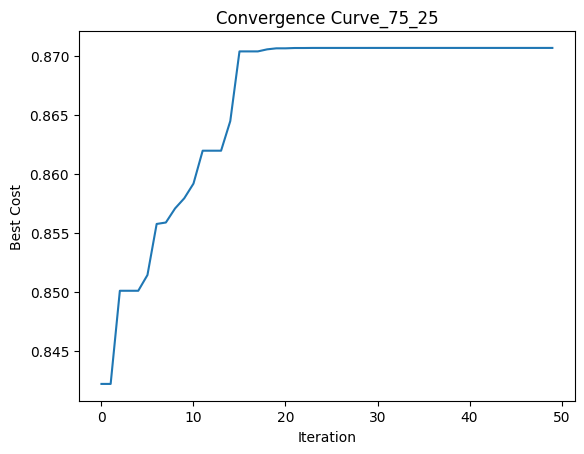

In [ ]:
plt.plot(fla_convergence_curve_75_25)
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('Convergence Curve_75_25')
plt.show()

# Flood Optimization Environmental priority

In [ ]:
import numpy as np
from tqdm import tqdm

def normalize(val, min, max):
    return (val - min) / (max - min+1e-8)

# FLA parameters
nPop = 25  # Number of particles (equivalent to population size)
MaxIt = 51  # Maximum number of iterations
Ne = 5  # Number of weak individuals to replace
# VarMin = [math.floor(N1_max * 0.7), 10, 170]  # Minimum values for N1, tilt_angle, azimuth_angle
# VarMax = [N1_max, 30, 190]  # Maximum values for N1, tilt_angle, azimuth_angle

VarMin = [N1_min, 0, 0]  # Minimum values for N1, tilt_angle, azimuth_angle
VarMax = [N1_max, 80, 360]  # Maximum values for N1, tilt_angle, azimuth_angle

# Initial upper and lower bounds
initial_vmax = np.array([8, 2, 4])
initial_vmin = np.array([-8, -2, -4])

# Number of iterations and shrink factor
final_shrink_factor = 0.9  # 1/10th of the original range

# Calculate shrink rate per iteration
shrink_rate = (1 - final_shrink_factor) / (MaxIt - 1)

# Initialize population and tracking variables
pop = np.zeros((nPop, 3))  # Each particle has 3 variables: N1, tilt_angle, azimuth_angle
pop_costs = np.full(nPop, -np.inf)
BestSol = {'Position': None, 'Cost': -np.inf}


# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Cost', 'Eco_cost', 'Env_cost', 'N1', 'Tilt', 'Azimuth', 'Adjusted_Energy', 'Avoided_CO2',
           'Avoided_Water_Evaporation', 'Total_Cost', 'NPV', 'LCOE', 'Payback_Period', 'IRR']
fla_25_75_df = pd.DataFrame(columns=columns)

# Random initialization of particles

for i in range(nPop):
    pop[i, 0] = np.random.randint(VarMin[0], VarMax[0])  # N1 (integer)
    pop[i, 1] = np.random.uniform(VarMin[1], VarMax[1])  # tilt_angle
    pop[i, 2] = np.random.uniform(VarMin[2], VarMax[2])  # azimuth_angle

    # Initial cost calculation
    N1, tilt_angle, azimuth_angle = pop[i]

    tilt_angle, azimuth_angle = round(tilt_angle, 1), round(azimuth_angle, 1)

    best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

    # costing
    norm_npv = normalize(NPV, npv_min, npv_max)
    #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
    #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
    norm_irr = normalize(IRR, irr_min, irr_max)
    norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost = 0.5*norm_npv + 0.5*norm_irr
    env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
    pop_costs[i] = 0.25*eco_cost + 0.75*env_cost


    if pop_costs[i] > BestSol['Cost']:
        BestSol = {'Position': pop[i].copy(), 'Cost': pop_costs[i]}


sorted_indices = np.argsort(pop_costs)

# print(pop)
# print("=============")

fla_convergence_curve_25_75 = []  # For tracking the best cost per iteration
fla_25_75 = []


# FLA main loop
for it in range(1,MaxIt):

    for i in range(nPop):
        # Phase I
        sorted_indices = np.argsort(pop_costs)
        Pe_i = ((pop_costs[i] - pop_costs[sorted_indices[0]]) /
                (pop_costs[sorted_indices[-1]] - pop_costs[sorted_indices[0]]+ 1e-8)) ** 2


        if np.random.rand() > (np.random.rand() + Pe_i):
            current_shrink_factor = 1 - i * shrink_rate
            # Calculate current bounds
            current_upper_bound = initial_vmax * current_shrink_factor
            current_lower_bound = initial_vmin * current_shrink_factor

            # Sample random values within current bounds
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = pop[i] + adjustment
        else:
            a = np.random.choice([j for j in range(nPop) if j != i])
            new_position = BestSol['Position'] + np.random.rand(3) * (pop[a] - pop[i])

        new_position = np.clip(new_position, VarMin, VarMax)
        new_position[0] = int(new_position[0])  # Ensure N1 remains an integer
        new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


        # costing
        norm_npv = normalize(NPV, npv_min, npv_max)
        #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
        #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
        norm_irr = normalize(IRR, irr_min, irr_max)
        norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
        norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

        #print(norm_npv,norm_lcoe,norm_payback_period,norm_irr)

        eco_cost = 0.5*norm_npv + 0.5*norm_irr
        env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
        new_cost = 0.25*eco_cost + 0.75*env_cost



        if new_cost > pop_costs[i]:
            pop[i] = new_position
            pop_costs[i] = new_cost
        if new_cost > BestSol['Cost']:
            BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        print(f"particle: {i} // Cost: {new_cost}// Variables: {new_position} // ")
        print("----------------------------------------------------------------------------------")

    # Phase II - Replace weak individuals
    Pt = abs(np.sin(np.random.rand() / (it)))
    if np.random.rand() < Pt:
        sorted_indices = np.argsort(pop_costs)
        pop = pop[sorted_indices][:nPop - Ne]
        pop_costs = pop_costs[sorted_indices][:nPop - Ne]

        new_individuals = []
        new_costs = []
        for _ in range(Ne):
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = BestSol['Position'] + adjustment
            new_position = np.clip(new_position, VarMin, VarMax)
            new_position[0] = int(new_position[0])
            new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
            best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


            # costing
            norm_npv = normalize(NPV, npv_min, npv_max)
            #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
            #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
            norm_irr = normalize(IRR, irr_min, irr_max)
            norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
            norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

            eco_cost = 0.5*norm_npv + 0.5*norm_irr
            env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
            new_cost = 0.25*eco_cost + 0.75*env_cost


            new_individuals.append(new_position)
            new_costs.append(new_cost)

            if new_cost > BestSol['Cost']:
                BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        pop = np.vstack([pop, new_individuals])
        pop_costs = np.hstack([pop_costs, new_costs])

    fla_convergence_curve_25_75.append(BestSol['Cost'])
    # print(pop)
    print("==========================================================================================")


    N1_save = BestSol['Position'][0]
    tilt_save = BestSol['Position'][1]
    azimuth_save = BestSol['Position'][2]
    _, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(BestSol['Position'][0], BestSol['Position'][1], BestSol['Position'][2])

    norm_npv = normalize(NPV, npv_min, npv_max)
    norm_irr = normalize(IRR, irr_min, irr_max)
    norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost = 0.5*norm_npv + 0.5*norm_irr
    env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation


    # Create a new row
    new_row = {
        'Iteration': it,
        'Cost': BestSol['Cost'],
        'Eco_cost': 0.25*eco_cost,
        'Env_cost': 0.75*env_cost,
        'N1': N1_save,
        'Tilt': tilt_save,
        'Azimuth': azimuth_save,
        'Adjusted_Energy': adjusted_energy,
        'Avoided_CO2': avoided_co2,
        'Avoided_Water_Evaporation': avoided_water_evaporation,
        'Total_Cost': Total_Cost,
        'NPV': NPV,
        'LCOE': LCOE,
        'Payback_Period': Payback_Period,
        'IRR': IRR
    }

    # Append the new row to the DataFrame
    fla_25_75_df = pd.concat([fla_25_75_df, pd.DataFrame([new_row])], ignore_index=True)

    print(f"Iteration {it}/{MaxIt}, Best Cost {BestSol['Cost']}, Variables: {BestSol['Position']}")
    print("==========================================================================================")


# Final best result
print("Best Solution:", BestSol['Position'])
print("Best Cost:", BestSol['Cost'])

# Save the dataset to a CSV file (optional)
fla_25_75_df.to_csv('fla_25_75.csv', index=False)

from google.colab import files

# Automatically download the file
files.download('fla_25_75.csv')


particle: 0 // Cost: 0.8478031474864728// Variables: [1310.    32.5  140.5] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.15787632428508466// Variables: [1101.    71.9   21.5] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.3478397309827733// Variables: [703.   53.6  79.5] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: 0.8008217081722251// Variables: [1135.    31.5  192.1] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.2607062869086238// Variables: [474.   43.7  96.5] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.8793669883634134// Variables: [1399.    28.2  164.2] // 
----------------------------------------------------------------------------------
particle: 6 // Cost: 0.2199

<ipython-input-32-209f2ac5d239>:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fla_25_75_df = pd.concat([fla_25_75_df, pd.DataFrame([new_row])], ignore_index=True)


Iteration 1/51, Best Cost 0.8817506730238165, Variables: [1399.    24.6  169.2]
particle: 0 // Cost: 0.8683874919762062// Variables: [1399.     0.    37.4] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.8808285998742069// Variables: [1383.    15.9  187.2] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.8705696109259082// Variables: [1399.     5.6  124.8] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: 0.14521321557636016// Variables: [1094.    72.9   25. ] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.2106644626582934// Variables: [408.   48.4 253.7] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.28285116431479// Variables: [1179.    59.1  352.3] // 
-----------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

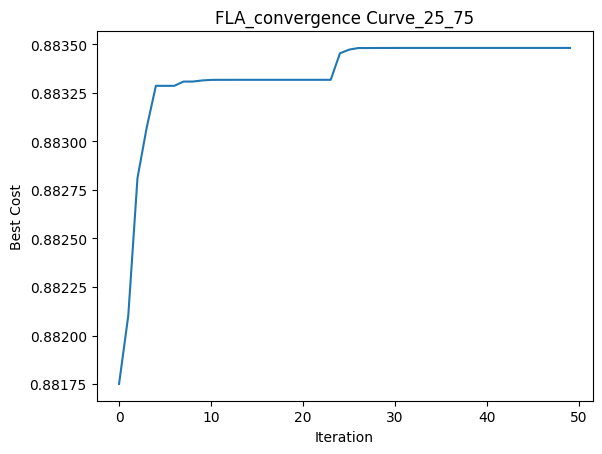

In [ ]:
plt.plot(fla_convergence_curve_25_75)
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('FLA_convergence Curve_25_75')
plt.show()

# Flood Optimization Enviro-economic priority

In [ ]:
import numpy as np
from tqdm import tqdm

def normalize(val, min, max):
    return (val - min) / (max - min+1e-8)

# FLA parameters
nPop = 25  # Number of particles (equivalent to population size)
MaxIt = 51  # Maximum number of iterations
Ne = 5  # Number of weak individuals to replace
# VarMin = [math.floor(N1_max * 0.7), 10, 170]  # Minimum values for N1, tilt_angle, azimuth_angle
# VarMax = [N1_max, 30, 190]  # Maximum values for N1, tilt_angle, azimuth_angle

VarMin = [N1_min, 0, 0]  # Minimum values for N1, tilt_angle, azimuth_angle
VarMax = [N1_max, 80, 360]  # Maximum values for N1, tilt_angle, azimuth_angle

# Initial upper and lower bounds
initial_vmax = np.array([16, 4, 8])
initial_vmin = np.array([-16, -4, -8])

# Number of iterations and shrink factor
final_shrink_factor = 0.9  # 1/10th of the original range

# Calculate shrink rate per iteration
shrink_rate = (1 - final_shrink_factor) / (MaxIt - 1)

# Initialize population and tracking variables
pop = np.zeros((nPop, 3))  # Each particle has 3 variables: N1, tilt_angle, azimuth_angle
pop_costs = np.full(nPop, -np.inf)
BestSol = {'Position': None, 'Cost': -np.inf}


# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Cost', 'Eco_cost', 'Env_cost', 'N1', 'Tilt', 'Azimuth', 'Adjusted_Energy', 'Avoided_CO2',
           'Avoided_Water_Evaporation', 'Total_Cost', 'NPV', 'LCOE', 'Payback_Period', 'IRR']
fla_50_50_df = pd.DataFrame(columns=columns)

# Random initialization of particles

for i in range(nPop):
    pop[i, 0] = np.random.randint(VarMin[0], VarMax[0])  # N1 (integer)
    pop[i, 1] = np.random.uniform(VarMin[1], VarMax[1])  # tilt_angle
    pop[i, 2] = np.random.uniform(VarMin[2], VarMax[2])  # azimuth_angle

    # Initial cost calculation
    N1, tilt_angle, azimuth_angle = pop[i]

    tilt_angle, azimuth_angle = round(tilt_angle, 1), round(azimuth_angle, 1)

    best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

    # costing
    norm_npv = normalize(NPV, npv_min, npv_max)
    #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
    #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
    norm_irr = normalize(IRR, irr_min, irr_max)
    norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost = 0.5*norm_npv + 0.5*norm_irr
    env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
    pop_costs[i] = 0.5*eco_cost + 0.5*env_cost


    if pop_costs[i] > BestSol['Cost']:
        BestSol = {'Position': pop[i].copy(), 'Cost': pop_costs[i]}


sorted_indices = np.argsort(pop_costs)

# print(pop)
# print("=============")

fla_convergence_curve_50_50 = []  # For tracking the best cost per iteration
fla_50_50 = []


# FLA main loop
for it in range(1,MaxIt):

    for i in range(nPop):
        # Phase I
        sorted_indices = np.argsort(pop_costs)
        Pe_i = ((pop_costs[i] - pop_costs[sorted_indices[0]]) /
                (pop_costs[sorted_indices[-1]] - pop_costs[sorted_indices[0]]+ 1e-8)) ** 2


        if np.random.rand() > (np.random.rand() + Pe_i):
            current_shrink_factor = 1 - i * shrink_rate
            # Calculate current bounds
            current_upper_bound = initial_vmax * current_shrink_factor
            current_lower_bound = initial_vmin * current_shrink_factor

            # Sample random values within current bounds
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = pop[i] + adjustment
        else:
            a = np.random.choice([j for j in range(nPop) if j != i])
            new_position = BestSol['Position'] + np.random.rand(3) * (pop[a] - pop[i])

        new_position = np.clip(new_position, VarMin, VarMax)
        new_position[0] = int(new_position[0])  # Ensure N1 remains an integer
        new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


        # costing
        norm_npv = normalize(NPV, npv_min, npv_max)
        #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
        #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
        norm_irr = normalize(IRR, irr_min, irr_max)
        norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
        norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

        #print(norm_npv,norm_lcoe,norm_payback_period,norm_irr)

        eco_cost = 0.5*norm_npv + 0.5*norm_irr
        env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
        new_cost = 0.5*eco_cost + 0.5*env_cost



        if new_cost > pop_costs[i]:
            pop[i] = new_position
            pop_costs[i] = new_cost
        if new_cost > BestSol['Cost']:
            BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        print(f"particle: {i} // Cost: {new_cost}// Variables: {new_position} // ")
        print("----------------------------------------------------------------------------------")

    # Phase II - Replace weak individuals
    Pt = abs(np.sin(np.random.rand() / (it)))
    if np.random.rand() < Pt:
        sorted_indices = np.argsort(pop_costs)
        pop = pop[sorted_indices][:nPop - Ne]
        pop_costs = pop_costs[sorted_indices][:nPop - Ne]

        new_individuals = []
        new_costs = []
        for _ in range(Ne):
            adjustment = np.random.uniform(current_lower_bound, current_upper_bound)
            adjustment[0]=round(adjustment[0])
            new_position = BestSol['Position'] + adjustment
            new_position = np.clip(new_position, VarMin, VarMax)
            new_position[0] = int(new_position[0])
            new_position[1], new_position[2] = round(new_position[1], 1), round(new_position[2], 1)
            best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(new_position[0], new_position[1], new_position[2])


            # costing
            norm_npv = normalize(NPV, npv_min, npv_max)
            #norm_lcoe = normalize(LCOE, lcoe_min, lcoe_max)
            #norm_payback_period = normalize(Payback_Period, payback_period_min, payback_period_max)
            norm_irr = normalize(IRR, irr_min, irr_max)
            norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
            norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

            eco_cost = 0.5*norm_npv + 0.5*norm_irr
            env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
            new_cost = 0.5*eco_cost + 0.5*env_cost


            new_individuals.append(new_position)
            new_costs.append(new_cost)

            if new_cost > BestSol['Cost']:
                BestSol = {'Position': new_position.copy(), 'Cost': new_cost}

        pop = np.vstack([pop, new_individuals])
        pop_costs = np.hstack([pop_costs, new_costs])

    fla_convergence_curve_50_50.append(BestSol['Cost'])
    # print(pop)
    print("==========================================================================================")


    N1_save = BestSol['Position'][0]
    tilt_save = BestSol['Position'][1]
    azimuth_save = BestSol['Position'][2]
    _, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(BestSol['Position'][0], BestSol['Position'][1], BestSol['Position'][2])

    norm_npv_save = normalize(NPV, npv_min, npv_max)
    norm_irr_save = normalize(IRR, irr_min, irr_max)
    norm_co2_save = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation_save = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost_save = 0.5*norm_npv_save + 0.5*norm_irr_save
    env_cost_save = 0.5*norm_co2_save + 0.5*norm_water_evaporation_save

    # Create a new row
    new_row = {
        'Iteration': it,
        'Cost': BestSol['Cost'],
        'Eco_cost': 0.5*eco_cost_save,
        'Env_cost': 0.5*env_cost_save,
        'N1': N1_save,
        'Tilt': tilt_save,
        'Azimuth': azimuth_save,
        'Adjusted_Energy': adjusted_energy,
        'Avoided_CO2': avoided_co2,
        'Avoided_Water_Evaporation': avoided_water_evaporation,
        'Total_Cost': Total_Cost,
        'NPV': NPV,
        'LCOE': LCOE,
        'Payback_Period': Payback_Period,
        'IRR': IRR
    }

    # Append the new row to the DataFrame
    fla_50_50_df = pd.concat([fla_50_50_df, pd.DataFrame([new_row])], ignore_index=True)

    print(f"Iteration {it}/{MaxIt}, Best Cost {BestSol['Cost']}, Variables: {BestSol['Position']}")
    print("==========================================================================================")


# Final best result
print("Best Solution:", BestSol['Position'])
print("Best Cost:", BestSol['Cost'])

# Save the dataset to a CSV file (optional)
fla_50_50_df.to_csv('fla_50_50.csv', index=False)

from google.colab import files

# Automatically download the file
files.download('fla_50_50.csv')


particle: 0 // Cost: 0.783427513712456// Variables: [1278.     4.4  255.7] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.8152842138939234// Variables: [1174.    0.   65.] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.70867761978501// Variables: [1079.    24.9   76.8] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: -0.05610976945346274// Variables: [1377.    54.8  345.9] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.755488489828938// Variables: [1399.     0.    12.8] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.5428142261315092// Variables: [1156.    48.    98.3] // 
----------------------------------------------------------------------------------
particle: 6 // Cost: 0.7763

<ipython-input-34-ac365fcc1614>:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fla_50_50_df = pd.concat([fla_50_50_df, pd.DataFrame([new_row])], ignore_index=True)


Iteration 1/51, Best Cost 0.8262113382819483, Variables: [1208.    0.   90.]
particle: 0 // Cost: 0.7917241335762403// Variables: [1214.    0.    0.] // 
----------------------------------------------------------------------------------
particle: 1 // Cost: 0.755488489828938// Variables: [1399.     0.    72.6] // 
----------------------------------------------------------------------------------
particle: 2 // Cost: 0.755488489828938// Variables: [1399.     0.     3.2] // 
----------------------------------------------------------------------------------
particle: 3 // Cost: 0.5116289687537023// Variables: [858.   43.3  87.3] // 
----------------------------------------------------------------------------------
particle: 4 // Cost: 0.5890929401972292// Variables: [1151.    48.4  102.2] // 
----------------------------------------------------------------------------------
particle: 5 // Cost: 0.8262113382819483// Variables: [1208.     0.   117.1] // 
------------------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

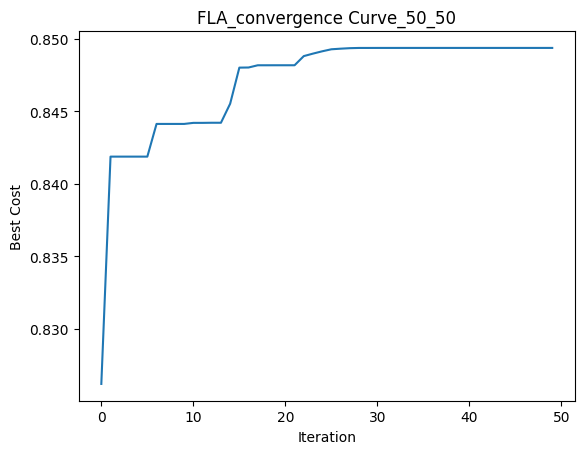

In [ ]:
plt.plot(fla_convergence_curve_50_50)
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('FLA_convergence Curve_50_50')
plt.show()

# Particle Swarm Optimization Economic priority

In [ ]:
# taking 1 decimal points for tilt & azimuth


import numpy as np


# PSO parameters
num_particles = 25  # Number of particles
num_iterations = 51  # Number of iterations
c1 = c2 = 2.1  # Acceleration coefficients
vmax = [16,4,8]  # Maximum velocity limit
vmin = [-16, -4,-8]

VarMin = [N1_min, 0, 0]  # Minimum values for N1, tilt_angle, azimuth_angle
VarMax = [N1_max, 80, 360]  # Maximum values for N1, tilt_angle, azimuth_angle

kappa = None  # To be calculated
c = c1 + c2  # Constriction factor parameter, must be > 4
#w = 0.7  # Inertia weight


# Constriction factor calculation
def calculate_kappa(c):
    return 2 / abs(2 - c - np.sqrt(c**2 - 4 * c))

kappa = calculate_kappa(c)


particles = np.zeros((num_particles, 3)) # Each particle has 3 variables: N1, tilt_angle, azimuth_angle
velocities = np.random.uniform(-0,4,(num_particles, 3))  # Initial velocities
pbest = np.copy(particles)  # Personal best
gbest = np.zeros(3)  # Global best


pbest_values = np.full(num_particles, -np.inf)  # Personal best NPV values
gbest_value = -np.inf  # Global best NPV value

pso_convergence_curve_75_25 = []

# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Cost', 'Eco_cost', 'Env_cost', 'N1', 'Tilt', 'Azimuth', 'Adjusted_Energy', 'Avoided_CO2',
           'Avoided_Water_Evaporation', 'Total_Cost', 'NPV', 'LCOE', 'Payback_Period', 'IRR']
pso_75_25_df = pd.DataFrame(columns=columns)

# Random initialization of particles
for i in range(num_particles):
    particles[i, 0] = np.random.randint(VarMin[0], VarMax[0])  # N1 (integer)
    particles[i, 1] = round(np.random.uniform(VarMin[1], VarMax[1]), 1)  # tilt_angle with 1 decimal places
    particles[i, 2] = round(np.random.uniform(VarMin[2], VarMax[2]), 1)  # azimuth_angle with 1 decimal places


# print(particles[:,0])

# PSO loop
for iteration in range(num_iterations):
    for i in range(num_particles):
        N1, tilt_angle, azimuth_angle = particles[i]


        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

        norm_npv = normalize(NPV, npv_min, npv_max)
        norm_irr = normalize(IRR, irr_min, irr_max)
        norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
        norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

        eco_cost = 0.5*norm_npv + 0.5*norm_irr
        env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
        cost = 0.75*eco_cost + 0.25*env_cost

        # Update personal best
        if cost > pbest_values[i]:
            pbest[i] = [N1, tilt_angle, azimuth_angle]
            pbest_values[i] = cost


        # Update global best
        if cost > gbest_value:
            gbest = [N1, tilt_angle, azimuth_angle]
            gbest_value = cost


        print(f"Particle: {i} // N1: {N1} // tilt: {tilt_angle} // az: {azimuth_angle} // cost: {cost:,}")
        print("---------------------------------------------------------------------------------------------------")



        # # Update particle velocities and positions
        #for i in range(num_particles):
        r1 = np.random.rand(3)  # Random coefficients r1 for each variable
        r2 = np.random.rand(3)  # Random coefficients r2 for each variable

        velocities[i] = kappa * (
            velocities[i]
            + c1 * r1 * (pbest[i] - particles[i])
            + c2 * r2 * (gbest - particles[i])
        )

        # Clamp velocity to vmax
        # print(f"kappa:{kappa}, c1: {c1}, r1: {r1}, r2: {r2}, pbest:{pbest[i]}, gbest: {gbest}, : {particles[i]} " )
        # print(f"v: {velocities[i]}")
        for var in range(3):
          velocities[i,var] = np.clip(velocities[i,var], vmin[var], vmax[var])
          if var==0:
            velocities[i,var]=round(velocities[i,var])
        # Update positions

        particles[i] = particles[i] + velocities[i]

        # Clamp particles within search space boundaries
        particles[i, 0] = int(particles[i, 0])
        particles[i, 0] = np.clip(particles[i, 0], VarMin[0], VarMax[0])  # N1 (integer)

        particles[i, 1] = round(float(np.clip(particles[i, 1], VarMin[1], VarMax[1])), 1)  # tilt_angle (float with 1 decimal places)
        particles[i, 2] = round(float(np.clip(particles[i, 2], VarMin[2], VarMax[2])), 1)  # azimuth_angle (float with 1 decimal places)



        #print(f"Velocity: {velocities[i]}")
        #print(f"Particle with velocity: {particles[i]}")

    pso_convergence_curve_75_25.append(gbest_value)

    N1_save = gbest[0]
    tilt_save = gbest[1]
    azimuth_save = gbest[2]
    _, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1_save, tilt_save, azimuth_save)

    norm_npv_save = normalize(NPV, npv_min, npv_max)
    norm_irr_save = normalize(IRR, irr_min, irr_max)
    norm_co2_save = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation_save = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost_save = 0.5*norm_npv_save + 0.5*norm_irr_save
    env_cost_save = 0.5*norm_co2_save + 0.5*norm_water_evaporation_save


    # Create a new row
    new_row = {
        'Iteration': iteration,
        'Cost': gbest_value,
        'Eco_cost': 0.75*eco_cost_save,
        'Env_cost': 0.25*env_cost_save,
        'N1': N1_save,
        'Tilt': tilt_save,
        'Azimuth': azimuth_save,
        'Adjusted_Energy': adjusted_energy,
        'Avoided_CO2': avoided_co2,
        'Avoided_Water_Evaporation': avoided_water_evaporation,
        'Total_Cost': Total_Cost,
        'NPV': NPV,
        'LCOE': LCOE,
        'Payback_Period': Payback_Period,
        'IRR': IRR
    }

    # Append the new row to the DataFrame
    pso_75_25_df = pd.concat([pso_75_25_df, pd.DataFrame([new_row])], ignore_index=True)

    # Print the best solution of the current iteration
    print("==================================================================================================")
    print(f"Iteration {iteration+1}/{num_iterations}, Best cost: {gbest_value:,}, Variables: {gbest}")
    print("==================================================================================================")


# Final best result
print("Best Solution:", gbest_value)
print("Best Cost:", gbest)

# Save the dataset to a CSV file (optional)
pso_75_25_df.to_csv('pso_75_25_df.csv', index=False)

from google.colab import files

# Automatically download the file
files.download('pso_75_25_df.csv')


Particle: 0 // N1: 1268.0 // tilt: 45.7 // az: 239.5 // cost: 0.5631120350174705
---------------------------------------------------------------------------------------------------
Particle: 1 // N1: 867.0 // tilt: 22.8 // az: 255.0 // cost: 0.7075993128686651
---------------------------------------------------------------------------------------------------
Particle: 2 // N1: 1145.0 // tilt: 35.6 // az: 164.4 // cost: 0.8406509811475511
---------------------------------------------------------------------------------------------------
Particle: 3 // N1: 1041.0 // tilt: 28.1 // az: 321.6 // cost: 0.5472946365858844
---------------------------------------------------------------------------------------------------
Particle: 4 // N1: 1026.0 // tilt: 7.1 // az: 242.7 // cost: 0.7582080088539792
---------------------------------------------------------------------------------------------------
Particle: 5 // N1: 758.0 // tilt: 31.1 // az: 292.7 // cost: 0.5902408135182687
-----------------

<ipython-input-36-fce7f062713a>:157: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pso_75_25_df = pd.concat([pso_75_25_df, pd.DataFrame([new_row])], ignore_index=True)


Iteration 1/51, Best cost: 0.8406509811475511, Variables: [1145.0, 35.6, 164.4]
Particle: 0 // N1: 1269.0 // tilt: 47.9 // az: 241.0 // cost: 0.48329190068234007
---------------------------------------------------------------------------------------------------
Particle: 1 // N1: 869.0 // tilt: 24.6 // az: 255.1 // cost: 0.7203267426675019
---------------------------------------------------------------------------------------------------
Particle: 2 // N1: 1146.0 // tilt: 37.3 // az: 165.6 // cost: 0.7682911068678064
---------------------------------------------------------------------------------------------------
Particle: 3 // N1: 1057.0 // tilt: 29.9 // az: 313.6 // cost: 0.5854648402966015
---------------------------------------------------------------------------------------------------
Particle: 4 // N1: 1042.0 // tilt: 11.1 // az: 234.7 // cost: 0.822564363697562
---------------------------------------------------------------------------------------------------
Particle: 5 // N

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

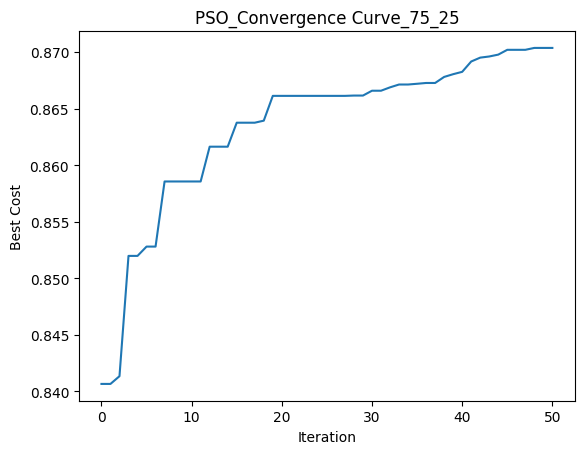

In [ ]:
plt.plot(pso_convergence_curve_75_25)
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('PSO_Convergence Curve_75_25')
plt.show()

# Particle Swarm Optimization Environmental priority

In [ ]:
# taking 1 decimal points for tilt & azimuth
tic = time.time()

import numpy as np


# PSO parameters
num_particles = 25  # Number of particles
num_iterations = 51  # Number of iterations
c1 = c2 = 2.1  # Acceleration coefficients
vmax = [16,4,8]  # Maximum velocity limit
vmin = [-16, -4,-8]

VarMin = [N1_min, 0, 0]  # Minimum values for N1, tilt_angle, azimuth_angle
VarMax = [N1_max, 80, 360]  # Maximum values for N1, tilt_angle, azimuth_angle

kappa = None  # To be calculated
c = c1 + c2  # Constriction factor parameter, must be > 4
#w = 0.7  # Inertia weight


# Constriction factor calculation
def calculate_kappa(c):
    return 2 / abs(2 - c - np.sqrt(c**2 - 4 * c))

kappa = calculate_kappa(c)


particles = np.zeros((num_particles, 3)) # Each particle has 3 variables: N1, tilt_angle, azimuth_angle
velocities = np.random.uniform(-0,4,(num_particles, 3))  # Initial velocities
pbest = np.copy(particles)  # Personal best
gbest = np.zeros(3)  # Global best


pbest_values = np.full(num_particles, -np.inf)  # Personal best NPV values
gbest_value = -np.inf  # Global best NPV value

pso_convergence_curve_25_75 = []

# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Cost', 'Eco_cost', 'Env_cost', 'N1', 'Tilt', 'Azimuth', 'Adjusted_Energy', 'Avoided_CO2',
           'Avoided_Water_Evaporation', 'Total_Cost', 'NPV', 'LCOE', 'Payback_Period', 'IRR']
pso_25_75_df = pd.DataFrame(columns=columns)

# Random initialization of particles
for i in range(num_particles):
    particles[i, 0] = np.random.randint(VarMin[0], VarMax[0])  # N1 (integer)
    particles[i, 1] = round(np.random.uniform(VarMin[1], VarMax[1]), 1)  # tilt_angle with 1 decimal places
    particles[i, 2] = round(np.random.uniform(VarMin[2], VarMax[2]), 1)  # azimuth_angle with 1 decimal places


# print(particles[:,0])

# PSO loop
for iteration in range(num_iterations):
    for i in range(num_particles):
        N1, tilt_angle, azimuth_angle = particles[i]


        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

        norm_npv = normalize(NPV, npv_min, npv_max)
        norm_irr = normalize(IRR, irr_min, irr_max)
        norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
        norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

        eco_cost = 0.5*norm_npv + 0.5*norm_irr
        env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
        cost = 0.25*eco_cost + 0.75*env_cost

        # Update personal best
        if cost > pbest_values[i]:
            pbest[i] = [N1, tilt_angle, azimuth_angle]
            pbest_values[i] = cost


        # Update global best
        if cost > gbest_value:
            gbest = [N1, tilt_angle, azimuth_angle]
            gbest_value = cost


        print(f"Particle: {i} // N1: {N1} // tilt: {tilt_angle} // az: {azimuth_angle} // cost: {cost:,}")
        print("---------------------------------------------------------------------------------------------------")



        # # Update particle velocities and positions
        #for i in range(num_particles):
        r1 = np.random.rand(3)  # Random coefficients r1 for each variable
        r2 = np.random.rand(3)  # Random coefficients r2 for each variable

        velocities[i] = kappa * (
            velocities[i]
            + c1 * r1 * (pbest[i] - particles[i])
            + c2 * r2 * (gbest - particles[i])
        )

        # Clamp velocity to vmax
        # print(f"kappa:{kappa}, c1: {c1}, r1: {r1}, r2: {r2}, pbest:{pbest[i]}, gbest: {gbest}, : {particles[i]} " )
        # print(f"v: {velocities[i]}")
        for var in range(3):
          velocities[i,var] = np.clip(velocities[i,var], vmin[var], vmax[var])
          if var==0:
            velocities[i,var]=round(velocities[i,var])
        # Update positions

        particles[i] = particles[i] + velocities[i]

        # Clamp particles within search space boundaries
        particles[i, 0] = int(particles[i, 0])
        particles[i, 0] = np.clip(particles[i, 0], VarMin[0], VarMax[0])  # N1 (integer)

        particles[i, 1] = round(float(np.clip(particles[i, 1], VarMin[1], VarMax[1])), 1)  # tilt_angle (float with 1 decimal places)
        particles[i, 2] = round(float(np.clip(particles[i, 2], VarMin[2], VarMax[2])), 1)  # azimuth_angle (float with 1 decimal places)



        #print(f"Velocity: {velocities[i]}")
        #print(f"Particle with velocity: {particles[i]}")

    pso_convergence_curve_25_75.append(gbest_value)

    N1_save = gbest[0]
    tilt_save = gbest[1]
    azimuth_save = gbest[2]
    _, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1_save, tilt_save, azimuth_save)

    norm_npv_save = normalize(NPV, npv_min, npv_max)
    norm_irr_save = normalize(IRR, irr_min, irr_max)
    norm_co2_save = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation_save = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost_save = 0.5*norm_npv_save + 0.5*norm_irr_save
    env_cost_save = 0.5*norm_co2_save + 0.5*norm_water_evaporation_save


    # Create a new row
    new_row = {
        'Iteration': iteration,
        'Cost': gbest_value,
        'Eco_cost': 0.25*eco_cost_save,
        'Env_cost': 0.75*env_cost_save,
        'N1': N1_save,
        'Tilt': tilt_save,
        'Azimuth': azimuth_save,
        'Adjusted_Energy': adjusted_energy,
        'Avoided_CO2': avoided_co2,
        'Avoided_Water_Evaporation': avoided_water_evaporation,
        'Total_Cost': Total_Cost,
        'NPV': NPV,
        'LCOE': LCOE,
        'Payback_Period': Payback_Period,
        'IRR': IRR
    }

    # Append the new row to the DataFrame
    pso_25_75_df = pd.concat([pso_25_75_df, pd.DataFrame([new_row])], ignore_index=True)

    # Print the best solution of the current iteration
    print("==================================================================================================")
    print(f"Iteration {iteration+1}/{num_iterations}, Best cost: {gbest_value:,}, Variables: {gbest}")
    print("==================================================================================================")


toc = time.time()

# Final best result
print("Best Solution:", gbest_value)
print("Best Cost:", gbest)
print(f"Elapsed time: {toc - tic:.2f} seconds")

# Save the dataset to a CSV file (optional)
pso_25_75_df.to_csv('pso_25_75_df.csv', index=False)

from google.colab import files

# Automatically download the file
files.download('pso_25_75_df.csv')


Particle: 0 // N1: 609.0 // tilt: 18.2 // az: 226.1 // cost: 0.4356940860028071
---------------------------------------------------------------------------------------------------
Particle: 1 // N1: 1086.0 // tilt: 58.1 // az: 348.3 // cost: 0.25617401824226743
---------------------------------------------------------------------------------------------------
Particle: 2 // N1: 624.0 // tilt: 13.4 // az: 233.1 // cost: 0.4505279881061778
---------------------------------------------------------------------------------------------------
Particle: 3 // N1: 1264.0 // tilt: 61.2 // az: 33.4 // cost: 0.34187821163923937
---------------------------------------------------------------------------------------------------
Particle: 4 // N1: 521.0 // tilt: 51.4 // az: 282.0 // cost: 0.23186976381263608
---------------------------------------------------------------------------------------------------
Particle: 5 // N1: 1324.0 // tilt: 16.8 // az: 42.8 // cost: 0.8244515697543691
----------------

<ipython-input-40-4e6e7190e984>:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pso_25_75_df = pd.concat([pso_25_75_df, pd.DataFrame([new_row])], ignore_index=True)


Iteration 1/51, Best cost: 0.8413217329742907, Variables: [1212.0, 11.4, 221.7]
Particle: 0 // N1: 609.0 // tilt: 20.4 // az: 226.6 // cost: 0.43411203948151644
---------------------------------------------------------------------------------------------------
Particle: 1 // N1: 1070.0 // tilt: 56.0 // az: 340.3 // cost: 0.30270157792262636
---------------------------------------------------------------------------------------------------
Particle: 2 // N1: 626.0 // tilt: 14.4 // az: 233.4 // cost: 0.4513195984307684
---------------------------------------------------------------------------------------------------
Particle: 3 // N1: 1248.0 // tilt: 57.2 // az: 41.4 // cost: 0.42545198267241
---------------------------------------------------------------------------------------------------
Particle: 4 // N1: 537.0 // tilt: 50.9 // az: 274.0 // cost: 0.2480573834942072
---------------------------------------------------------------------------------------------------
Particle: 5 // N1: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

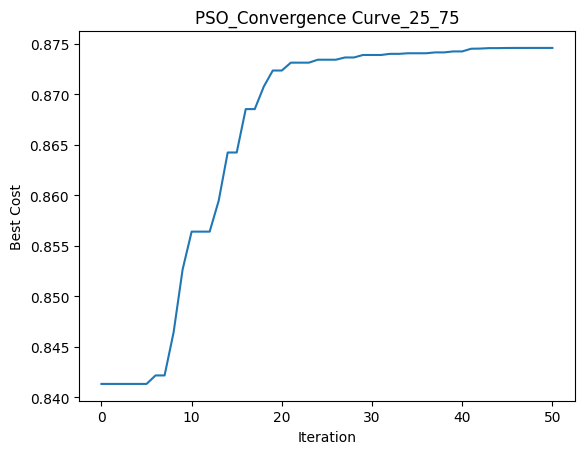

In [ ]:
plt.plot(pso_convergence_curve_25_75)
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('PSO_Convergence Curve_25_75')
plt.show()

# Particle Swarm Optimization Enviro-economic priority

In [ ]:
# taking 1 decimal points for tilt & azimuth
import numpy as np


# PSO parameters
num_particles = 25  # Number of particles
num_iterations = 51  # Number of iterations
c1 = c2 = 2.1  # Acceleration coefficients
vmax = [16,4,8]  # Maximum velocity limit
vmin = [-16, -4,-8]

VarMin = [N1_min, 0, 0]  # Minimum values for N1, tilt_angle, azimuth_angle
VarMax = [N1_max, 80, 360]  # Maximum values for N1, tilt_angle, azimuth_angle

kappa = None  # To be calculated
c = c1 + c2  # Constriction factor parameter, must be > 4
#w = 0.7  # Inertia weight


# Constriction factor calculation
def calculate_kappa(c):
    return 2 / abs(2 - c - np.sqrt(c**2 - 4 * c))

kappa = calculate_kappa(c)


particles = np.zeros((num_particles, 3)) # Each particle has 3 variables: N1, tilt_angle, azimuth_angle
velocities = np.random.uniform(-0,4,(num_particles, 3))  # Initial velocities
pbest = np.copy(particles)  # Personal best
gbest = np.zeros(3)  # Global best


pbest_values = np.full(num_particles, -np.inf)  # Personal best NPV values
gbest_value = -np.inf  # Global best NPV value

pso_convergence_curve_50_50 = []

# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Cost', 'Eco_cost', 'Env_cost', 'N1', 'Tilt', 'Azimuth', 'Adjusted_Energy', 'Avoided_CO2',
           'Avoided_Water_Evaporation', 'Total_Cost', 'NPV', 'LCOE', 'Payback_Period', 'IRR']
pso_50_50_df = pd.DataFrame(columns=columns)

# Random initialization of particles
for i in range(num_particles):
    particles[i, 0] = np.random.randint(VarMin[0], VarMax[0])  # N1 (integer)
    particles[i, 1] = round(np.random.uniform(VarMin[1], VarMax[1]), 1)  # tilt_angle with 1 decimal places
    particles[i, 2] = round(np.random.uniform(VarMin[2], VarMax[2]), 1)  # azimuth_angle with 1 decimal places


# print(particles[:,0])

# PSO loop
for iteration in range(num_iterations):
    for i in range(num_particles):
        N1, tilt_angle, azimuth_angle = particles[i]


        best_sizing, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1, tilt_angle, azimuth_angle)

        norm_npv = normalize(NPV, npv_min, npv_max)
        norm_irr = normalize(IRR, irr_min, irr_max)
        norm_co2 = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
        norm_water_evaporation = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

        eco_cost = 0.5*norm_npv + 0.5*norm_irr
        env_cost = 0.5*norm_co2 + 0.5*norm_water_evaporation
        cost = 0.5*eco_cost + 0.5*env_cost

        # Update personal best
        if cost > pbest_values[i]:
            pbest[i] = [N1, tilt_angle, azimuth_angle]
            pbest_values[i] = cost


        # Update global best
        if cost > gbest_value:
            gbest = [N1, tilt_angle, azimuth_angle]
            gbest_value = cost


        print(f"Particle: {i} // N1: {N1} // tilt: {tilt_angle} // az: {azimuth_angle} // cost: {cost:,}")
        print("---------------------------------------------------------------------------------------------------")



        # # Update particle velocities and positions
        #for i in range(num_particles):
        r1 = np.random.rand(3)  # Random coefficients r1 for each variable
        r2 = np.random.rand(3)  # Random coefficients r2 for each variable

        velocities[i] = kappa * (
            velocities[i]
            + c1 * r1 * (pbest[i] - particles[i])
            + c2 * r2 * (gbest - particles[i])
        )

        # Clamp velocity to vmax
        # print(f"kappa:{kappa}, c1: {c1}, r1: {r1}, r2: {r2}, pbest:{pbest[i]}, gbest: {gbest}, : {particles[i]} " )
        # print(f"v: {velocities[i]}")
        for var in range(3):
          velocities[i,var] = np.clip(velocities[i,var], vmin[var], vmax[var])
          if var==0:
            velocities[i,var]=round(velocities[i,var])
        # Update positions

        particles[i] = particles[i] + velocities[i]

        # Clamp particles within search space boundaries
        particles[i, 0] = int(particles[i, 0])
        particles[i, 0] = np.clip(particles[i, 0], VarMin[0], VarMax[0])  # N1 (integer)

        particles[i, 1] = round(float(np.clip(particles[i, 1], VarMin[1], VarMax[1])), 1)  # tilt_angle (float with 1 decimal places)
        particles[i, 2] = round(float(np.clip(particles[i, 2], VarMin[2], VarMax[2])), 1)  # azimuth_angle (float with 1 decimal places)



        #print(f"Velocity: {velocities[i]}")
        #print(f"Particle with velocity: {particles[i]}")

    pso_convergence_curve_50_50.append(gbest_value)

    N1_save = gbest[0]
    tilt_save = gbest[1]
    azimuth_save = gbest[2]
    _, adjusted_energy, avoided_co2, avoided_water_evaporation, Total_Cost, NPV, LCOE, Payback_Period, IRR = calculate_all_parameters(N1_save, tilt_save, azimuth_save)

    norm_npv_save = normalize(NPV, npv_min, npv_max)
    norm_irr_save = normalize(IRR, irr_min, irr_max)
    norm_co2_save = normalize(avoided_co2, avoided_co2_min, avoided_co2_max)
    norm_water_evaporation_save = normalize(avoided_water_evaporation, avoided_water_evaporation_min, avoided_water_evaporation_max)

    eco_cost_save = 0.5*norm_npv_save + 0.5*norm_irr_save
    env_cost_save = 0.5*norm_co2_save + 0.5*norm_water_evaporation_save


    # Create a new row
    new_row = {
        'Iteration': iteration,
        'Cost': gbest_value,
        'Eco_cost': 0.5*eco_cost_save,
        'Env_cost': 0.5*env_cost_save,
        'N1': N1_save,
        'Tilt': tilt_save,
        'Azimuth': azimuth_save,
        'Adjusted_Energy': adjusted_energy,
        'Avoided_CO2': avoided_co2,
        'Avoided_Water_Evaporation': avoided_water_evaporation,
        'Total_Cost': Total_Cost,
        'NPV': NPV,
        'LCOE': LCOE,
        'Payback_Period': Payback_Period,
        'IRR': IRR
    }

    # Append the new row to the DataFrame
    pso_50_50_df = pd.concat([pso_50_50_df, pd.DataFrame([new_row])], ignore_index=True)

    # Print the best solution of the current iteration
    print("==================================================================================================")
    print(f"Iteration {iteration+1}/{num_iterations}, Best cost: {gbest_value:,}, Variables: {gbest}")
    print("==================================================================================================")


# Final best result
print("Best Solution:", gbest_value)
print("Best Cost:", gbest)

# Save the dataset to a CSV file (optional)
pso_50_50_df.to_csv('pso_50_50_df.csv', index=False)

from google.colab import files

# Automatically download the file
files.download('pso_50_50_df.csv')


Particle: 0 // N1: 564.0 // tilt: 14.4 // az: 214.7 // cost: 0.5500488219977253
---------------------------------------------------------------------------------------------------
Particle: 1 // N1: 950.0 // tilt: 52.4 // az: 189.1 // cost: 0.7542060860258095
---------------------------------------------------------------------------------------------------
Particle: 2 // N1: 1047.0 // tilt: 5.4 // az: 51.4 // cost: 0.7581283838491871
---------------------------------------------------------------------------------------------------
Particle: 3 // N1: 492.0 // tilt: 36.1 // az: 74.2 // cost: 0.3842544019427182
---------------------------------------------------------------------------------------------------
Particle: 4 // N1: 1003.0 // tilt: 12.4 // az: 16.1 // cost: 0.7343183269489821
---------------------------------------------------------------------------------------------------
Particle: 5 // N1: 1164.0 // tilt: 77.0 // az: 100.5 // cost: 0.27147219722313076
--------------------

<ipython-input-34-cbd31bcacc17>:157: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pso_50_50_df = pd.concat([pso_50_50_df, pd.DataFrame([new_row])], ignore_index=True)


Iteration 1/51, Best cost: 0.8185050074724654, Variables: [1283.0, 47.1, 170.7]
Particle: 0 // N1: 566.0 // tilt: 16.3 // az: 215.4 // cost: 0.5506370485532531
---------------------------------------------------------------------------------------------------
Particle: 1 // N1: 950.0 // tilt: 53.6 // az: 191.4 // cost: 0.7486682500314998
---------------------------------------------------------------------------------------------------
Particle: 2 // N1: 1049.0 // tilt: 6.5 // az: 52.2 // cost: 0.7689165162067242
---------------------------------------------------------------------------------------------------
Particle: 3 // N1: 508.0 // tilt: 36.0 // az: 66.2 // cost: 0.3900869362905526
---------------------------------------------------------------------------------------------------
Particle: 4 // N1: 1019.0 // tilt: 8.9 // az: 24.1 // cost: 0.7083576576706935
---------------------------------------------------------------------------------------------------
Particle: 5 // N1: 1159

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

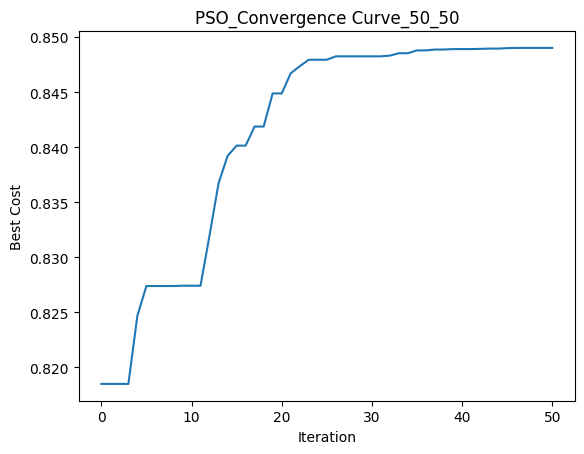

In [ ]:
plt.plot(pso_convergence_curve_50_50)
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('PSO_Convergence Curve_50_50')
plt.show()